In [1]:
# Install a pip package in the current Jupyter kernel
import subprocess
import sys
subprocess.call([sys.executable,"-m","pip","install","numpy","gspread","oauth2client","df2gspread","pandas","matplotlib","seaborn", "pandas-profiling"])


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


0

In [609]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from pandas.api.types import is_numeric_dtype, is_string_dtype
import gspread
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap
from itertools import chain
from oauth2client.service_account import ServiceAccountCredentials
import time
from collections import defaultdict
from pathlib import Path
from matplotlib.patches import ConnectionPatch

In [199]:
pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 6000)
pd.set_option('display.width', 6000)
pd.options.display.max_colwidth = 0

In [200]:
data = pd.read_csv("../collected_data/raw_results.csv")
# ProfileReport(data)

def get_column_full_name(keyword_on_column):
    for column in data.columns:
        if keyword_on_column in column:
            return column

for col in data.columns:
    print(col)

Educational attainment
Area of study (e.g. Computer Science, Civil engineering)
Professional Experience in Software development
Current role
Country
Rate your level of agreement with the following statements.  [I have experience with tools that allow the creation of diagrams from plain text or code (e.g. PlantUML, Mermaid.JS, others).]
Rate your level of agreement with the following statements.  [I am familiar with the Unified Modeling Language (UML).]
Rate your level of agreement with the following statements.  [I am familiar with UML component diagrams.]
Rate your level of agreement with the following statements.  [I am familiar with UML deployment diagrams.]
I think that with Infragenie, it is easy to... [create architectural diagrams.]
I think that with Infragenie, it is easy to... [keep architectural diagrams updated.]
I think that with Infragenie, it is easy to... [keep architectural diagrams consistent with the source-code.]
I think that with Infragenie, it is easy to... [add ne

In [212]:
category_names = ['Strongly disagree', 'Disagree',
                  'Neutral', 'Agree', 'Strongly agree']

def generate_likert_graph(results, path, category_names=category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(12.5, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(True)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        #rects = ax.barh(labels, widths, left=starts, height=0.5,
        #               label=colname, color=color)
        ax.barh(labels, widths, left=starts, height=0.9,
                label=colname, color=color)
        xcenters = starts + widths / 2
        
        
        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)) + '%' if int(c) > 0 else '', ha='center', va='center',
                    color=text_color, fontsize='large', weight='demibold')
        
        # ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, -0.2),
              loc='lower left', fontsize='large')
    plt.savefig(path, format='pdf', bbox_inches='tight')
    plt.show()
    return fig, ax

def likert_scale_order(level):
    if 'Strongly disagree' == level:
        return 1
    elif 'Disagree' == level:
        return 2
    elif 'Neutral' == level:
        return 3
    elif 'Agree' == level:
        return 4
    elif 'Strongly agree' == level:
        return 5
    elif 'Strongly Agree' == level:
        return 5
    else:
        return 0

    
def get_likert_data_sorted(data):
    sample_size = len(data)
    occurrences = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0} 
    
    for point in data:
        # ugky workaround to deal with a typo in the form
        if point == 'Strongly Agree':
            point = 'Strongly agree'
        occurrences[point] = occurrences[point] + 1
    
    dist= {key: round((value / sample_size), 2) * 100 for key, value in occurrences.items()}
    #dist= {key: value for key, value in occurrences.items()}
    #dist_sorted = dict(sorted(dist.items(), key=lambda item: likert_scale_order(item[0])))
    
    #return list(dist_sorted.values())
    return list(dist.values())


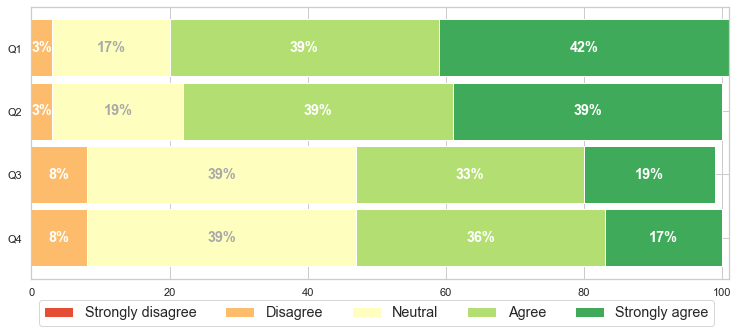

(<Figure size 900x360 with 1 Axes>, <AxesSubplot:>)

In [213]:
# Familiariaty with UML

q1_answers = data[get_column_full_name('PlantUML')]
q2_answers = data[get_column_full_name('Unified Modeling Language')]
q3_answers = data[get_column_full_name('component diagrams')]
q4_answers = data[get_column_full_name('deployment diagrams')]

results = {
    'Q1': get_likert_data_sorted(q1_answers),
    'Q2': get_likert_data_sorted(q2_answers),
    'Q3': get_likert_data_sorted(q3_answers),
    'Q4': get_likert_data_sorted(q4_answers),
}

filepath = Path('../figures/uml_knowledge.pdf')
generate_likert_graph(results, filepath)

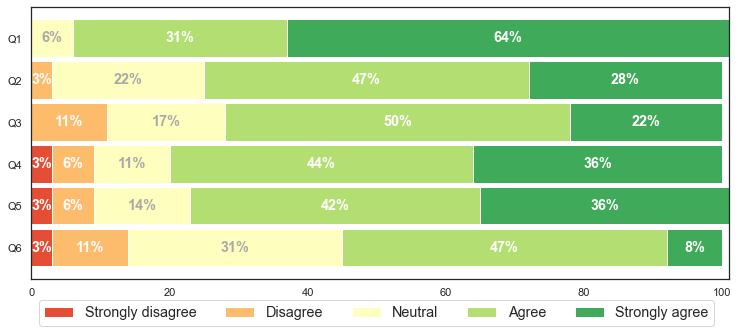

(<Figure size 900x360 with 1 Axes>, <AxesSubplot:>)

In [409]:
# ease of use

q1_answers = data[get_column_full_name('create architectural diagrams')]
q2_answers = data[get_column_full_name('keep architectural diagrams updated')]
q3_answers = data[get_column_full_name('keep architectural diagrams consistent with the source-code')]
q4_answers = data[get_column_full_name('add new information (not inferred from the source-code) to the diagrams')]
q5_answers = data[get_column_full_name('change the generated architectural diagrams')]
q6_answers = data[get_column_full_name('verify how changes may impact the architecture')]

results = {
    'Q1': get_likert_data_sorted(q1_answers),
    'Q2': get_likert_data_sorted(q2_answers),
    'Q3': get_likert_data_sorted(q3_answers),
    'Q4': get_likert_data_sorted(q4_answers),
    'Q5': get_likert_data_sorted(q5_answers),
    'Q6': get_likert_data_sorted(q6_answers),
}

filepath = Path('../figures/infragenie-ease-of-use.pdf')
generate_likert_graph(results, filepath)

In [410]:
#sns.set_theme(style="white")

#experience = [10, 4, 1]
#likert = [[2, 4, 1, 4, 5, 3], [2, 4, 5, 3, 2, 1], [1, 2, 3, 4, 5, 5]]

#data_plot = pd.DataFrame(likert, experience, columns=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6'])
#sns.lineplot(x = "Experience level", y = "Scale", data=data_plot)
#plt.show()
#ax = sns.lineplot(data=data_plot, linewidth=2.5, marker="o", linestyle=(0, (1, 1)), ci=None, dashes=[(1,0), (1,0), (1,0), (1,0), (1,0), (1,0)])
#plt.legend(bbox_to_anchor=(1.01, 1), title='Questions')
#ax.set(ylim=[1,5], xlim=[min(experience), max(experience)], yticklabels = ['Str Dis','','Disagree','','Neutral','','Agree','','Str Agr'], xlabel="Experience", ylabel="Answers")
#plt.show()

# Knowledge questions weights
weight_q1 = {'Strongly disagree': 0, 'Disagree': 2, 'Neutral': 4, 'Agree': 6, 'Strongly agree': 8}
weight_q2 = {'Strongly disagree': 0, 'Disagree': 3, 'Neutral': 6, 'Agree': 9, 'Strongly agree': 12}
weight_q3 = {'Strongly disagree': 0, 'Disagree': 1, 'Neutral': 2, 'Agree': 3, 'Strongly agree': 4}
weight_q4 = {'Strongly disagree': 0, 'Disagree': 1, 'Neutral': 2, 'Agree': 3, 'Strongly agree': 4}
weights = [weight_q1, weight_q2, weight_q3, weight_q4]

sns.set_theme(style="whitegrid")

# Get only the knowledge related questions
experience_raw_data = data.iloc[:, 5:9]

experience = []
for index, rows in experience_raw_data.iterrows():
    sum = 0
    for i, r in enumerate(rows):
        sum = sum + weights[i][r]
    experience.append(sum)

experience_raw_data.assign(ExpValue=experience)

def get_answers_by_experience(questions_raw_data):
    # cross answers with the experience
    questions_raw_data.insert(0, 'ExpValue', experience)
    answers_by_experience = defaultdict(pd.DataFrame)

    for i, row in questions_raw_data.iterrows():
        if answers_by_experience[row['ExpValue']].empty:
            answers_by_experience[row['ExpValue']] = row.iloc[1:].transform(lambda item: likert_scale_order(item))
        else:
            answers_by_experience[row['ExpValue']] = answers_by_experience[row['ExpValue']].append(row.iloc[1:].transform(lambda item: likert_scale_order(item)))    
    
    return answers_by_experience


def get_average_responses_by_experience(questions_raw_data, answers_keywords):
    answers_by_experience = get_answers_by_experience(questions_raw_data)
    average_responses = []
    exp = []
    for key, value in answers_by_experience.items():
        exp.append(key)
        avg_for_experience = []
        for key in answers_keywords:
            total_sum = value[get_column_full_name(key)].sum()
            average = int(total_sum / (value.shape[0] / len(answers_keywords)))
            avg_for_experience.append(average)
        average_responses.append(avg_for_experience)
    
    return (exp, average_responses)


def plot_response_by_experience_relation(columns):
    data_plot = pd.DataFrame(average_responses, exp, columns=columns)
    dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=dims)
    dashes = [(1, 0) for _ in columns]
    sns.lineplot(ax=ax, data=data_plot, linewidth=2.5, marker="o", linestyle=(0, (1, 1)), ci=None, dashes=dashes)
    plt.legend(bbox_to_anchor=(1.009, 1.01), title='Questions')
    ax.set(ylim=[1,5], xlim=[min(experience), max(experience)], yticklabels = ['Str Dis','','Disagree','','Neutral','','Agree','','Str Agr'], xlabel="Experience", ylabel="Answers")
    plt.show()



In [413]:
sns.set_theme(style="whitegrid")

answers_keywords = ['create architectural diagrams',
                   'keep architectural diagrams updated',
                    'keep architectural diagrams consistent with the source-code',
                    'add new information (not inferred from the source-code)',
                    'change the generated architectural diagrams',
                    'verify how changes may impact the architecture'
                   ]
columns=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']



ease_of_use_raw_data = data.iloc[:, 9:15]

#exp, average_responses = get_average_responses_by_experience(ease_of_use_raw_data, answers_keywords)
#plot_response_by_experience_relation(columns)

In [560]:
def plot_heat_map(x_col, y_col, xlabel, ylabel, title, filepath):
    sns.set_theme(style="white")
    y_labels = ["Strongly agree", "Agree", "Neutral", "Disagree","Strongly disagree"]
    x_labels = ["Strongly disagree", "Disagree", "Neutral","Agree", "Strongly agree"]

    strg_disg_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}
    disg_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}
    neutral_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}
    agree_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}
    strg_agree_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}

    for a, b in zip(x_col, y_col):
        if a == 'Strongly disagree':
            strg_disg_map[b] = strg_disg_map[b] + 1
        elif a == 'Disagree':
            disg_map[b] = disg_map[b] + 1
        elif a == 'Neutral':
            neutral_map[b] = neutral_map[b] + 1
        elif a == 'Agree':
            agree_map[b] = agree_map[b] + 1
        elif a == 'Strongly agree' or a == 'Strongly Agree':
            if b == 'Strongly Agree':
                b = 'Strongly agree'
            strg_agree_map[b] = strg_agree_map[b] + 1

        
    str_disg_group = list(strg_disg_map.values())
    disg_group = list(disg_map.values())
    neutral_group = list(neutral_map.values())
    agree_group = list(agree_map.values())
    str_agree_group = list(strg_agree_map.values())
            
    data_dist = np.array([str_agree_group,
                          agree_group,
                          neutral_group,
                          disg_group,
                          str_disg_group
                         ])


    dims = (14.7, 9.27)
    fig, ax = plt.subplots(figsize=dims)
    cmap = plt.get_cmap("YlOrBr")
    im = ax.imshow(data_dist, cmap=cmap)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_labels)), labels=x_labels)
    ax.set_yticks(np.arange(len(y_labels)), labels=y_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, data_dist[i, j], ha="center", va="center", color="black")

    ax.set_title(title, fontsize='large', fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_xlabel(xlabel, fontweight='bold')
    fig.tight_layout()
    plt.savefig(filepath, format='pdf', bbox_inches='tight')
    plt.show()


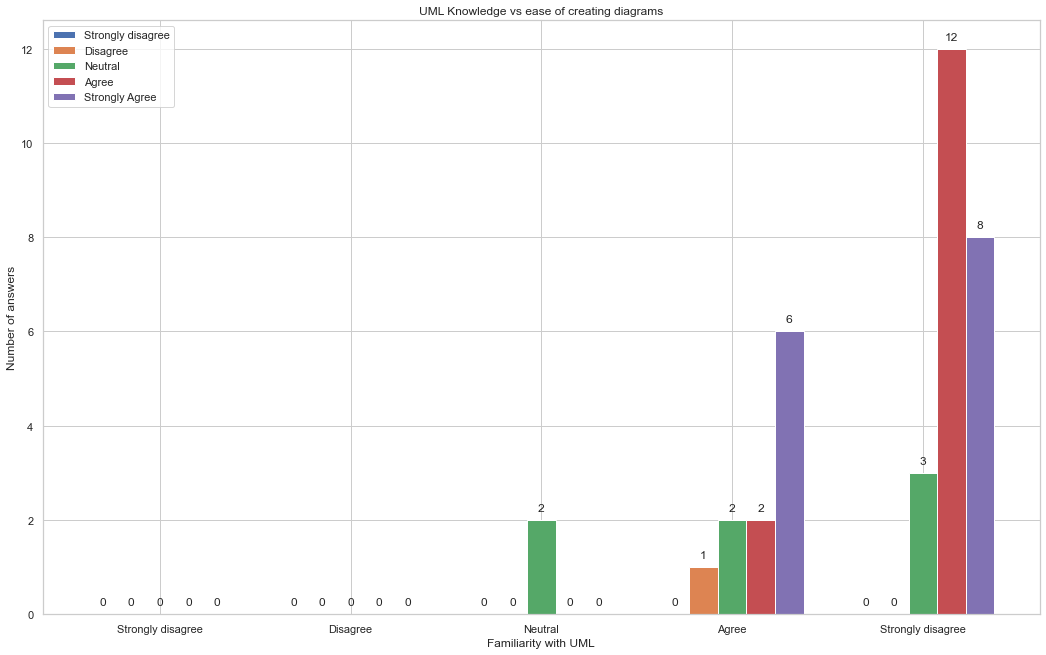

In [417]:
# Experience with UML vs Create Architecture Diagrams


uml_col = data[get_column_full_name('Unified Modeling Language')]
create_architectures_col = data[get_column_full_name('create architectural diagrams')]


data_rows = data.iloc[:, [6, 9]]


strg_disg_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}
disg_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}
neutral_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}
agree_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}
strg_agree_map = {'Strongly disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly agree': 0}

for row in zip(uml_col, create_architectures_col):
    if row[0] == 'Strongly disagree':
        strg_disg_map[row[1]] = strg_disg_map[row[1]] + 1
    elif row[0] == 'Disagree':
        disg_map[row[1]] = disg_map[row[1]] + 1
    elif row[0] == 'Neutral':
        neutral_map[row[1]] = neutral_map[row[1]] + 1
    elif row[0] == 'Agree':
        agree_map[row[1]] = agree_map[row[1]] + 1
    elif row[0] == 'Strongly agree':
        strg_agree_map[row[1]] = strg_agree_map[row[1]] + 1

        
labels = ['Strongly disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly disagree']

str_disg_group = list(strg_disg_map.values())
disg_group = list(disg_map.values())
neutral_group = list(neutral_map.values())
agree_group = list(agree_map.values())
str_agree_group = list(strg_agree_map.values())


x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

dims = (14.7, 9.27)
fig, ax = plt.subplots(figsize=dims)
rects1 = ax.bar(x - 2*width, str_disg_group, width, label='Strongly disagree')
rects2 = ax.bar(x - width, disg_group, width, label='Disagree')
rects3 = ax.bar(x, neutral_group, width, label='Neutral')
rects4 = ax.bar(x + width, agree_group, width, label='Agree')
rects5 = ax.bar(x + 2*width, str_agree_group, width, label='Strongly Agree')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of answers')
ax.set_xlabel('Familiarity with UML')
ax.set_title('UML Knowledge vs ease of creating diagrams')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=7)
ax.bar_label(rects2, padding=7)
ax.bar_label(rects3, padding=7)
ax.bar_label(rects4, padding=7)
ax.bar_label(rects5, padding=7)

fig.tight_layout()

filepath = Path('../figures/uml_vs_knowledge.pdf')
#plt.savefig(filepath, format='pdf', bbox_inches='tight')
#plt.show()

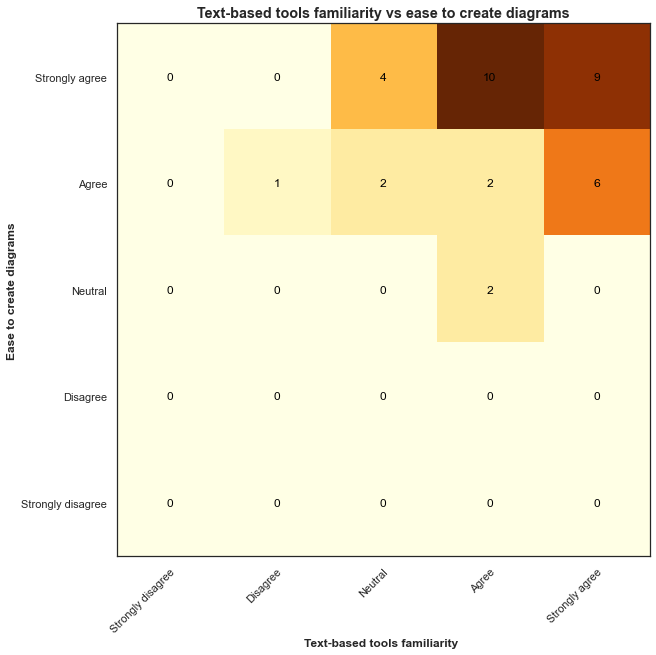

In [676]:
# # Experience with PlantUML vs Create Architecture Diagrams

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('create architectural diagrams')]

title = "Text-based tools familiarity vs ease to create diagrams"
xlabel = 'Text-based tools familiarity '
ylabel = 'Ease to create diagrams'

filepath = Path('../figures_ease_of_use/plantuml_vs_create.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)


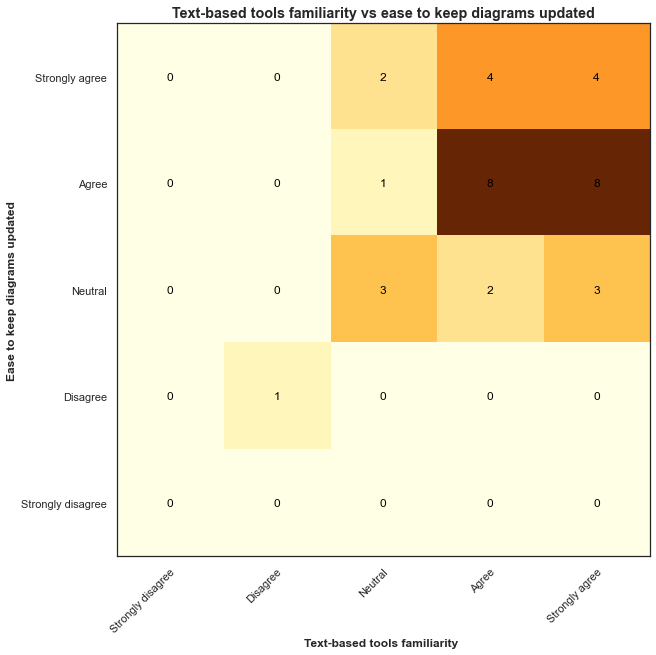

In [677]:
# Experience with PlantUML vs Keep updated

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('keep architectural diagrams updated')]

title = "Text-based tools familiarity vs ease to keep diagrams updated"
xlabel = 'Text-based tools familiarity '
ylabel = 'Ease to keep diagrams updated'

filepath = Path('../figures_ease_of_use/plantuml_vs_keep_updated.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

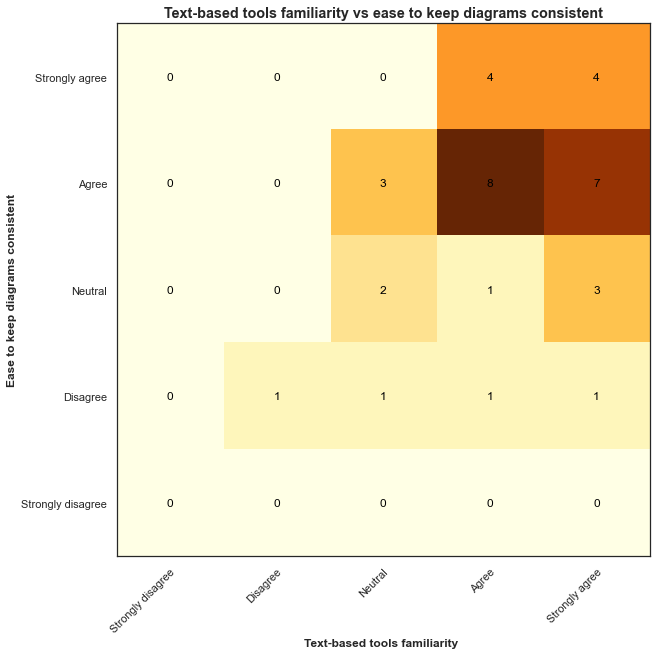

In [678]:
# Experience with PlantUML vs Keep consistent

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('keep architectural diagrams consistent with the source-code')]

title = "Text-based tools familiarity vs ease to keep diagrams consistent"
xlabel = 'Text-based tools familiarity '
ylabel = 'Ease to keep diagrams consistent'

filepath = Path('../figures_ease_of_use/plantuml_vs_keep_consistent.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

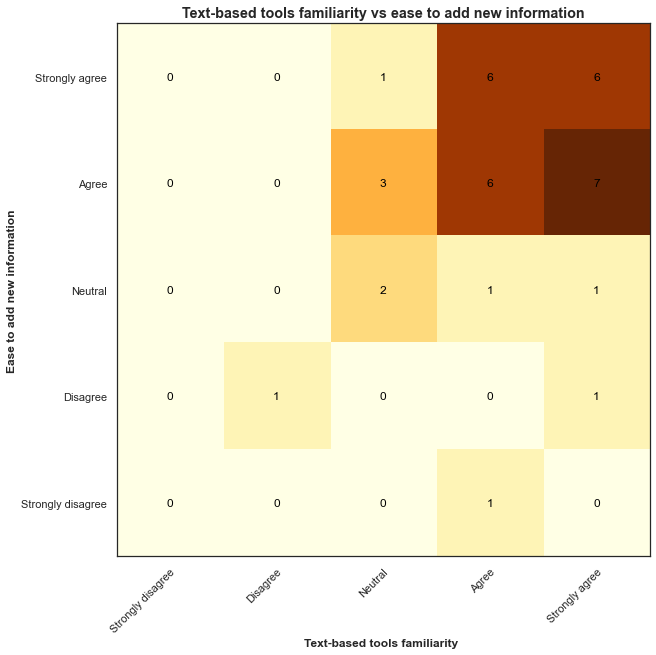

In [679]:
# Experience with PlantUML vs add new information

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('add new information (not inferred from the source-code) to the diagrams')]

title = "Text-based tools familiarity vs ease to add new information"
xlabel = 'Text-based tools familiarity '
ylabel = 'Ease to add new information'

filepath = Path('../figures_ease_of_use/plantuml_vs_add_information.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

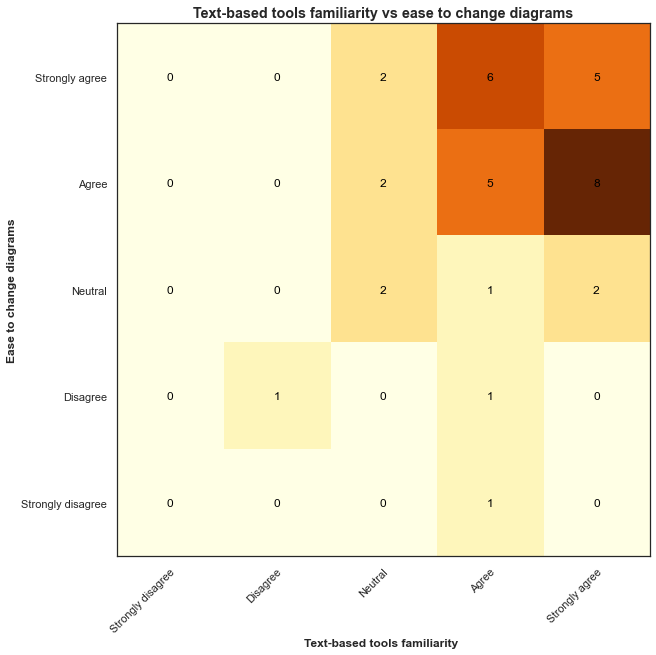

In [680]:
# Experience with PlantUML vs change diagrams

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('change the generated architectural diagrams')]

title = "Text-based tools familiarity vs ease to change diagrams"
xlabel = 'Text-based tools familiarity '
ylabel = 'Ease to change diagrams'

filepath = Path('../figures_ease_of_use/plantuml_vs_change_diagrams.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

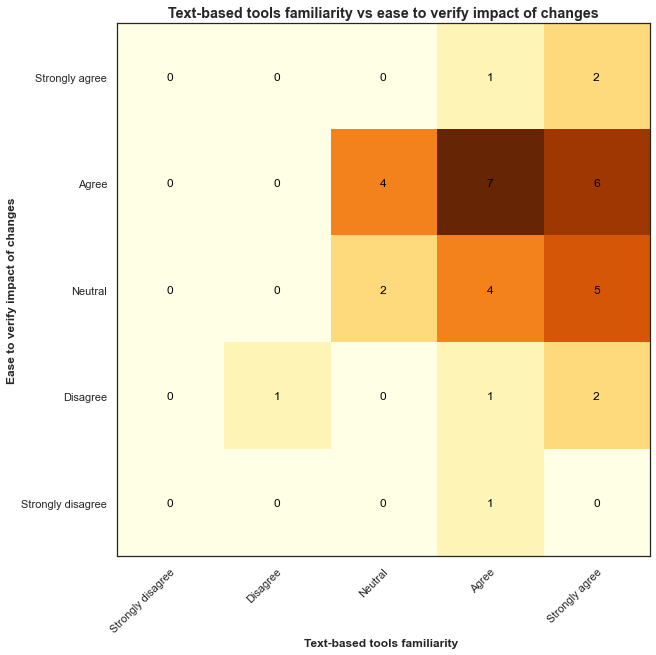

In [681]:
# Experience with PlantUML vs verify impact of changes

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('verify how changes may impact the architecture')]

title = "Text-based tools familiarity vs ease to verify impact of changes"
xlabel = 'Text-based tools familiarity '
ylabel = 'Ease to verify impact of changes'

filepath = Path('../figures_ease_of_use/plantuml_vs_changes_impact.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

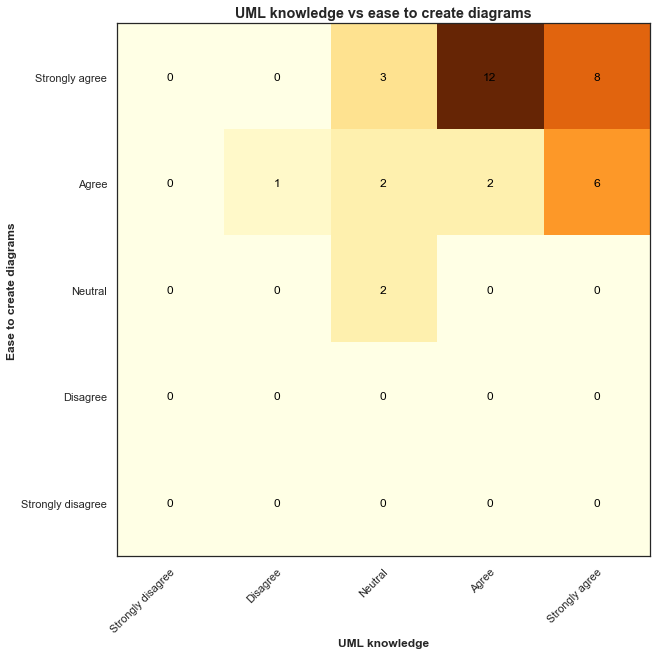

In [682]:
# UML knowledge vs verify impact of changes

a = data[get_column_full_name('Unified Modeling Language')]
b =  data[get_column_full_name('create architectural diagrams')]

title = "UML knowledge vs ease to create diagrams"
xlabel = 'UML knowledge'
ylabel = 'Ease to create diagrams'

filepath = Path('../figures_ease_of_use/uml_vs_create.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

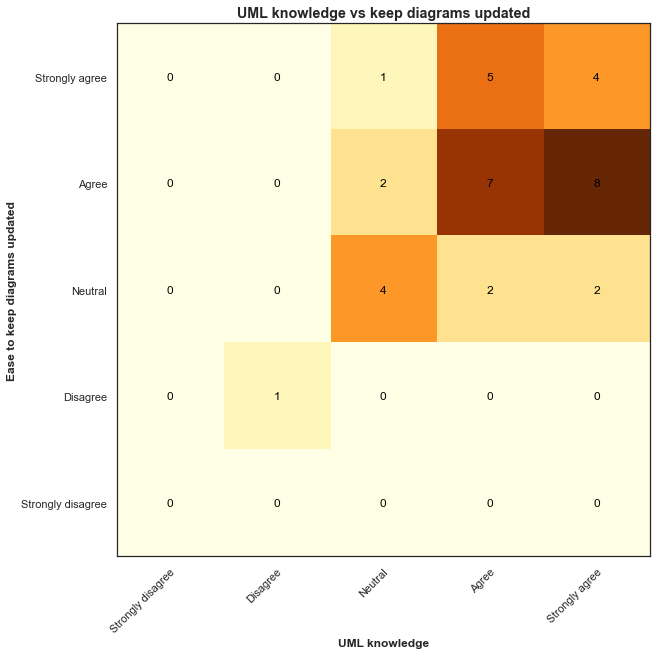

In [683]:
# UML knowledge vs keep updated

a = data[get_column_full_name('Unified Modeling Language')]
b =  data[get_column_full_name('keep architectural diagrams updated')]

title = "UML knowledge vs keep diagrams updated"
xlabel = 'UML knowledge'
ylabel = 'Ease to keep diagrams updated'

filepath = Path('../figures_ease_of_use/uml_vs_keep_updated.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

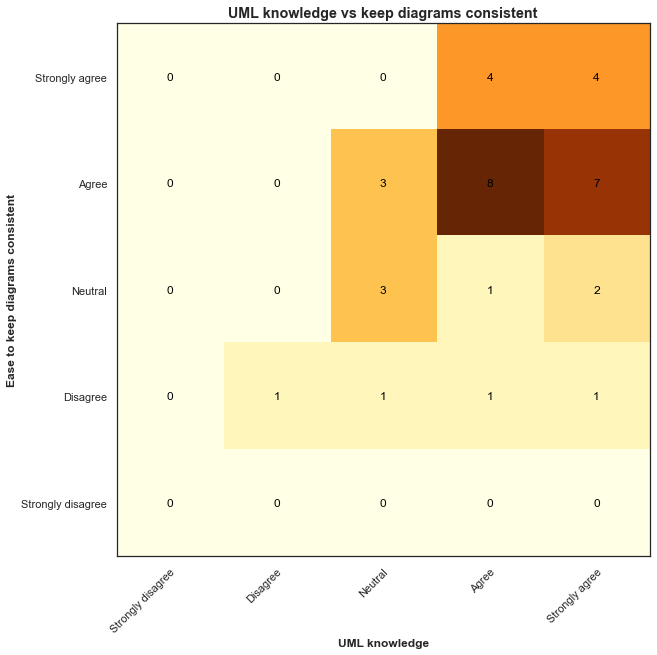

In [684]:
# UML knowledge vs keep consistent

a = data[get_column_full_name('Unified Modeling Language')]
b =  data[get_column_full_name('keep architectural diagrams consistent with the source-code')]

title = "UML knowledge vs keep diagrams consistent"
xlabel = 'UML knowledge'
ylabel = 'Ease to keep diagrams consistent'

filepath = Path('../figures_ease_of_use/uml_vs_keep_consistent.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

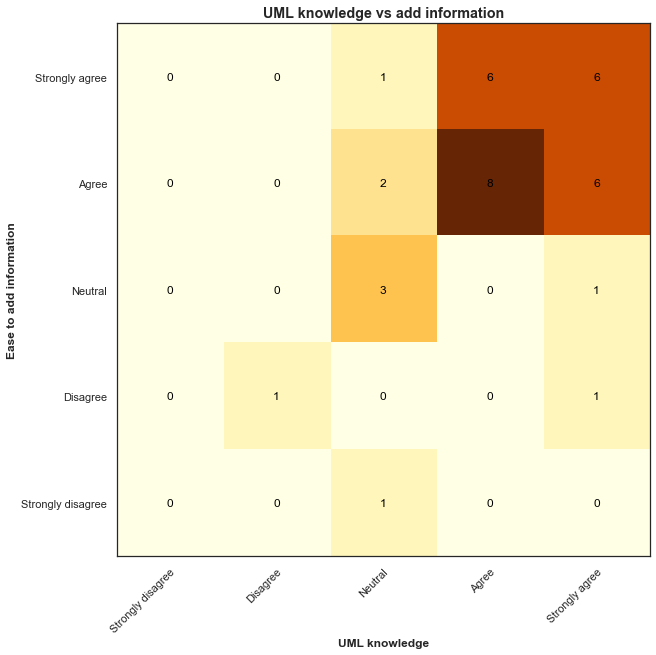

In [685]:
# UML knowledge vs add new information

a = data[get_column_full_name('Unified Modeling Language')]
b =  data[get_column_full_name('add new information (not inferred from the source-code) to the diagrams')]

title = "UML knowledge vs add information"
xlabel = 'UML knowledge'
ylabel = 'Ease to add information'

filepath = Path('../figures_ease_of_use/uml_vs_add_information.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

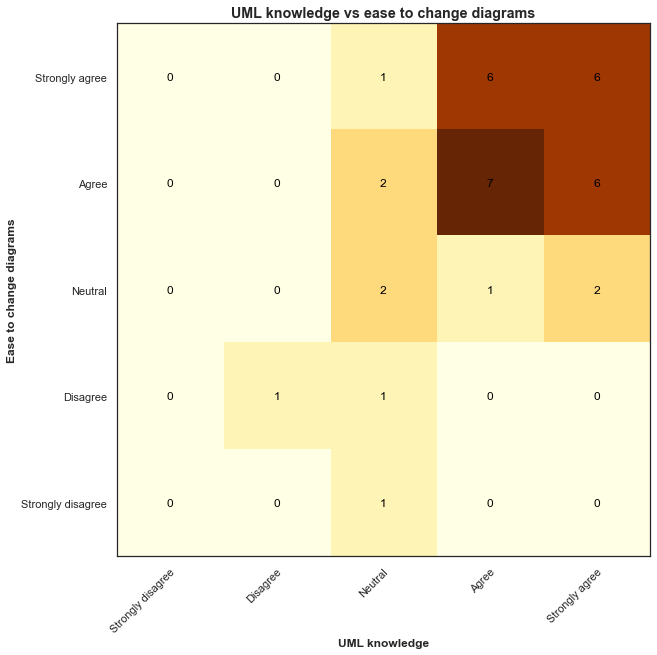

In [686]:
# UML knowledge vs change diagrams

a = data[get_column_full_name('Unified Modeling Language')]
b =  data[get_column_full_name('change the generated architectural diagrams')]

title = "UML knowledge vs ease to change diagrams"
xlabel = 'UML knowledge'
ylabel = 'Ease to change diagrams'

filepath = Path('../figures_ease_of_use/uml_vs_change diagrams.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

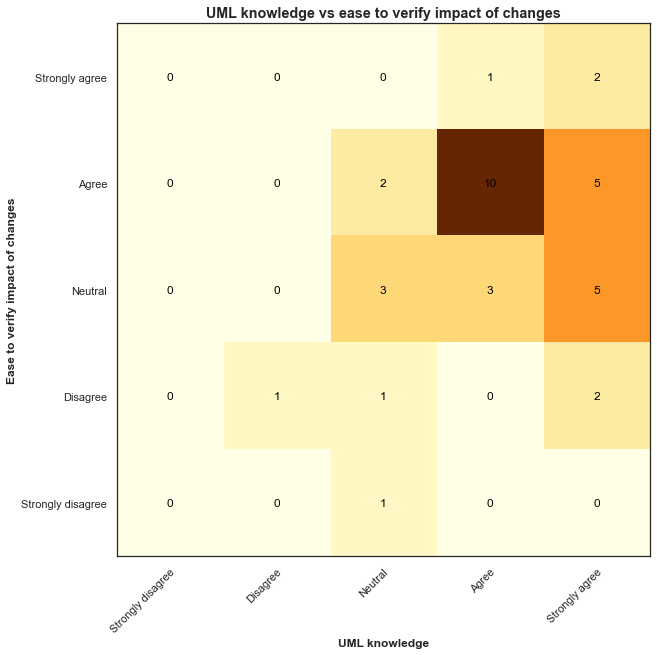

In [687]:
# UML knowledge vs impact of changes

a = data[get_column_full_name('Unified Modeling Language')]
b =  data[get_column_full_name('verify how changes may impact the architecture')]

title = "UML knowledge vs ease to verify impact of changes"
xlabel = 'UML knowledge'
ylabel = 'Ease to verify impact of changes'

filepath = Path('../figures_ease_of_use/uml_vs_impact_of_changes.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

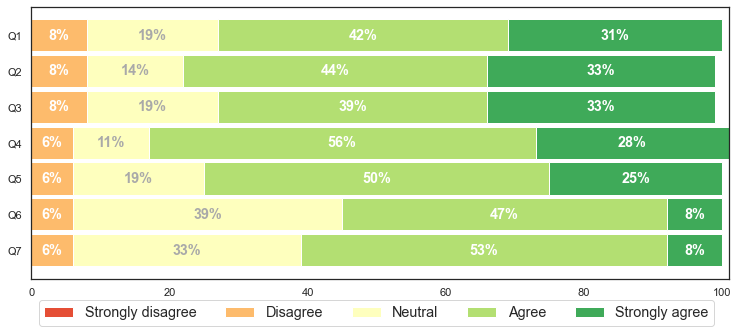

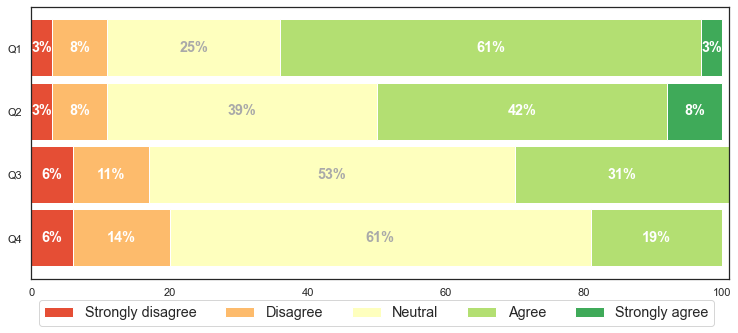

(<Figure size 900x360 with 1 Axes>, <AxesSubplot:>)

In [668]:
# usefulness - first question

q1_answers = data[get_column_full_name('[complete.]')]
q2_answers = data[get_column_full_name('[consistent.]')]
q3_answers = data[get_column_full_name('[precise.]')]
q4_answers = data[get_column_full_name('[easier to consult.]')]
q5_answers = data[get_column_full_name('[easier to understand.]')]
q6_answers = data[get_column_full_name('[easier to maintain.]')]
q7_answers = data[get_column_full_name('[easier to update.]')]
q8_answers = data[get_column_full_name('[plan future changes on the architecture.]')]
q9_answers = data[get_column_full_name('[understand the impact of changes in the architecture.]')]
q10_answers = data[get_column_full_name('[be more confident while introducing architectural changes.]')]
q11_answers = data[get_column_full_name('[implement architectural changes faster.]')]

results_first_half = {
    'Q1': get_likert_data_sorted(q1_answers),
    'Q2': get_likert_data_sorted(q2_answers),
    'Q3': get_likert_data_sorted(q3_answers),
    'Q4': get_likert_data_sorted(q4_answers),
    'Q5': get_likert_data_sorted(q5_answers),
    'Q6': get_likert_data_sorted(q6_answers),
    'Q7': get_likert_data_sorted(q7_answers),
}

results_second_half = {
    'Q1': get_likert_data_sorted(q8_answers),
    'Q2': get_likert_data_sorted(q9_answers),
    'Q3': get_likert_data_sorted(q10_answers),
    'Q4': get_likert_data_sorted(q11_answers),
}

filepath = Path('../figures/usefulness-documentation.pdf')
generate_likert_graph(results_first_half, filepath)
# ax.set(title="Inexperienced")

filepath = Path('../figures/usefulness-future-changes.pdf')
generate_likert_graph(results_second_half, filepath)


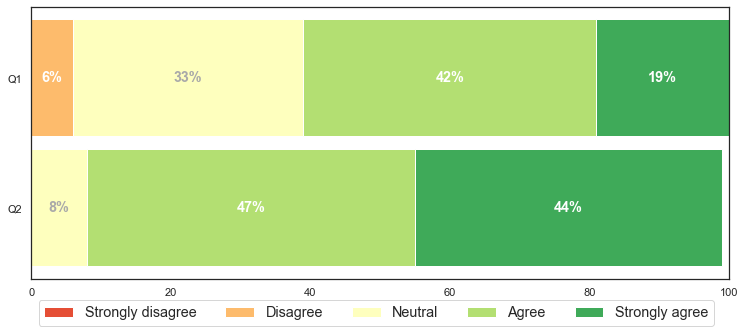

(<Figure size 900x360 with 1 Axes>, <AxesSubplot:>)

In [494]:
# usefulness - second question


q1_answers = data[get_column_full_name('[a complete view of the architecture.]')]
q2_answers = data[get_column_full_name('[the most relevant elements of the architecture.]')]

results = {
    'Q1': get_likert_data_sorted(q1_answers),
    'Q2': get_likert_data_sorted(q2_answers),
}

filepath = Path('../figures/usefulness-diagram.pdf')
generate_likert_graph(results, filepath)

/var/folders/03/hllvd2q10f58y1x9ys6xdqwc0000gq/T/ipykernel_6706/3281927539.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answers_by_experience[row['ExpValue']] = answers_by_experience[row['ExpValue']].append(row.iloc[1:].transform(lambda item: likert_scale_order(item)))
/var/folders/03/hllvd2q10f58y1x9ys6xdqwc0000gq/T/ipykernel_6706/3281927539.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answers_by_experience[row['ExpValue']] = answers_by_experience[row['ExpValue']].append(row.iloc[1:].transform(lambda item: likert_scale_order(item)))
/var/folders/03/hllvd2q10f58y1x9ys6xdqwc0000gq/T/ipykernel_6706/3281927539.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answers_by_experience[row['ExpValue']] = answe

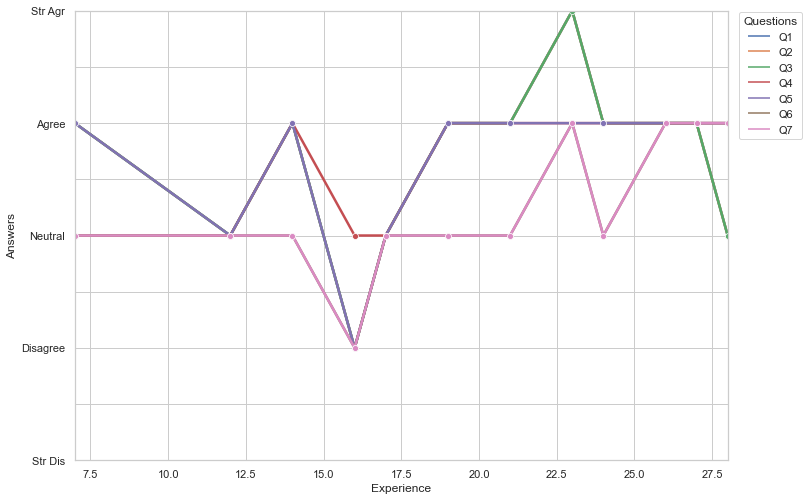

In [495]:
# usefulness - relation with knowledge

sns.set_theme(style="whitegrid")

answers_keywords_first_half = ['[complete.]',
                   '[consistent.]',
                    '[precise.]',
                    '[easier to consult.]',
                    '[easier to understand.]',
                    '[easier to maintain.]',
                    '[easier to update.]'
                   ]

q8_answers = data[get_column_full_name('[plan future changes on the architecture.]')]
q9_answers = data[get_column_full_name('[understand the impact of changes in the architecture.]')]
q10_answers = data[get_column_full_name('[be more confident while introducing architectural changes.]')]
q11_answers = data[get_column_full_name('[implement architectural changes faster.]')]


columns=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7']

usefulness_first_half_raw = data.iloc[:, 15:22]


exp, average_responses = get_average_responses_by_experience(usefulness_first_half_raw, answers_keywords_first_half)
plot_response_by_experience_relation(columns)


answers_keywords_second_half = ['[plan future changes on the architecture.]',
                   '[understand the impact of changes in the architecture.]',
                    '[be more confident while introducing architectural changes.]',
                    '[implement architectural changes faster.]',
                   ]

q8_answers = data[get_column_full_name('[plan future changes on the architecture.]')]
q9_answers = data[get_column_full_name('[understand the impact of changes in the architecture.]')]
q10_answers = data[get_column_full_name('[be more confident while introducing architectural changes.]')]
q11_answers = data[get_column_full_name('[implement architectural changes faster.]')]


columns=['Q1', 'Q2', 'Q3', 'Q4']

usefulness_second_half_raw = data.iloc[:, 22:26]


#exp, average_responses = get_average_responses_by_experience(usefulness_second_half_raw, answers_keywords_second_half)
#plot_response_by_experience_relation(columns)





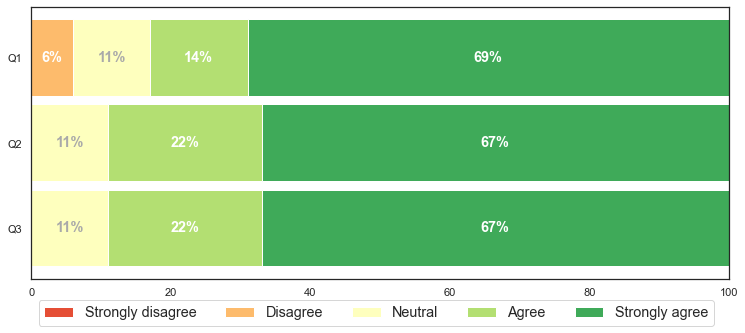

(<Figure size 900x360 with 1 Axes>, <AxesSubplot:>)

In [528]:
# usefulness - editor section


q1_answers = data[get_column_full_name('[increase the diagram value.]')]
q2_answers = data[get_column_full_name('[make the diagram more consistent.]')]
q3_answers = data[get_column_full_name('[representing details that were not automatically captured.]')]

results = {
    'Q1': get_likert_data_sorted(q1_answers),
    'Q2': get_likert_data_sorted(q2_answers),
    'Q3': get_likert_data_sorted(q3_answers),
}

filepath = Path('../figures/usefulness-edit-capabilities.pdf')
generate_likert_graph(results, filepath)

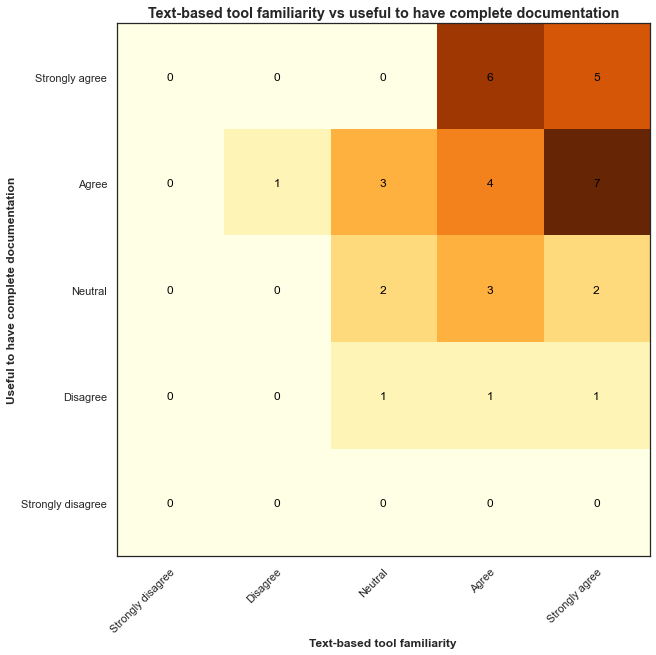

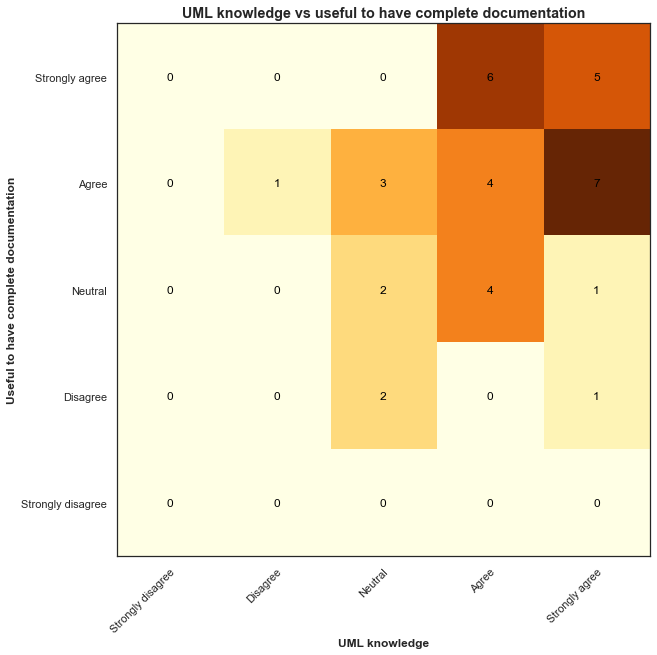

In [689]:
# plant uml familiarity vs useful to have complete documentation


a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('complete.')]

title = "Text-based tool familiarity vs useful to have complete documentation"
xlabel = 'Text-based tool familiarity'
ylabel = 'Useful to have complete documentation'

filepath = Path('../figures_usefulness/plantuml_vs_doc_complete.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to have complete documentation

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful to have complete documentation"
xlabel = 'UML knowledge'
ylabel = 'Useful to have complete documentation'

filepath = Path('../figures_usefulness/uml_vs_doc_complete.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

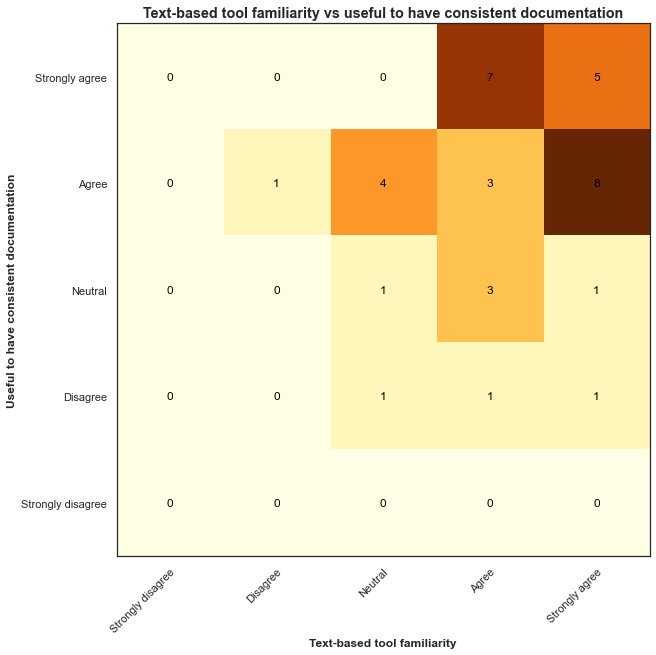

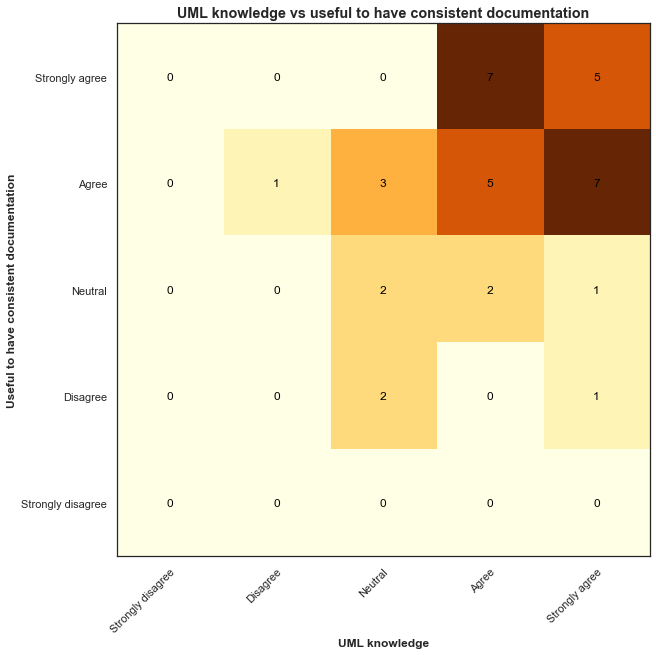

In [690]:
# plant uml familiarity vs useful to have consistent documentation

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('consistent.')]

title = "Text-based tool familiarity vs useful to have consistent documentation"
xlabel = 'Text-based tool familiarity'
ylabel = 'Useful to have consistent documentation'

filepath = Path('../figures_usefulness/plantuml_vs_doc_consistent.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to have consistent documentation

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful to have consistent documentation"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_doc_consistent.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

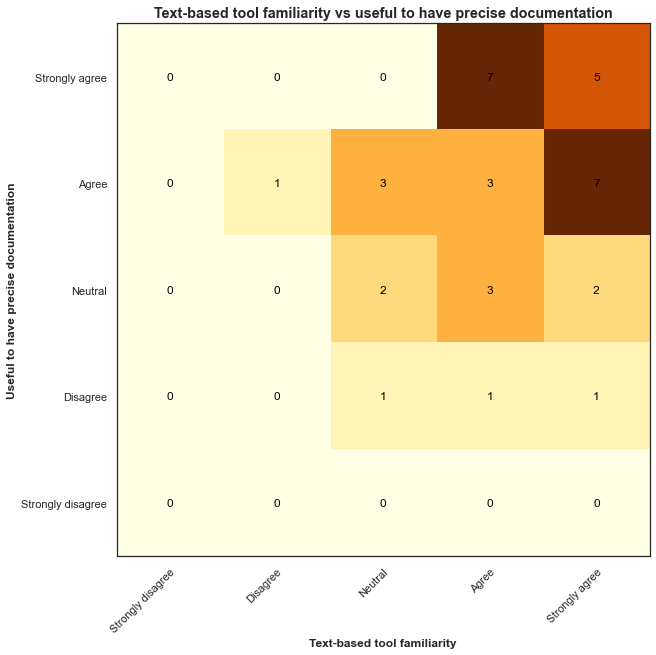

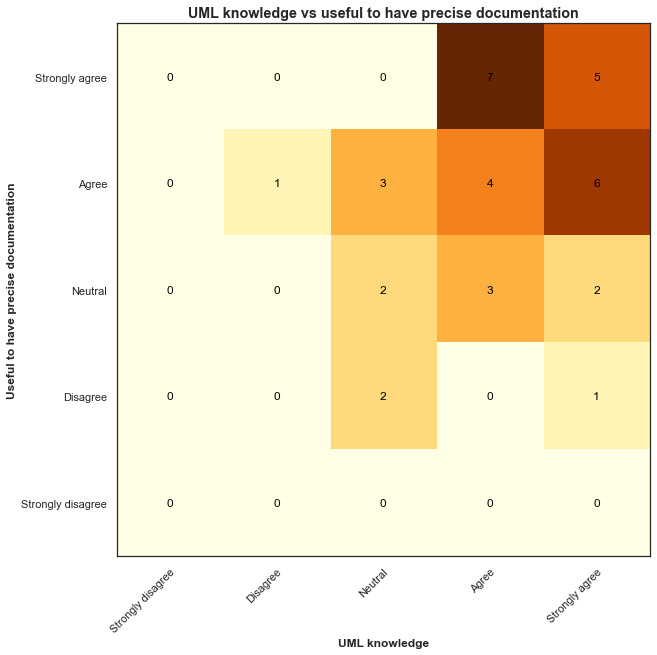

In [691]:
# plant uml familiarity vs useful to have precise documentation

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('precise.')]

title = "Text-based tool familiarity vs useful to have precise documentation"
xlabel = 'Text-based tool familiarity'
ylabel = 'Useful to have precise documentation'

filepath = Path('../figures_usefulness/plantuml_vs_doc_precise.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to have complete documentation

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful to have precise documentation"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_doc_precise.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

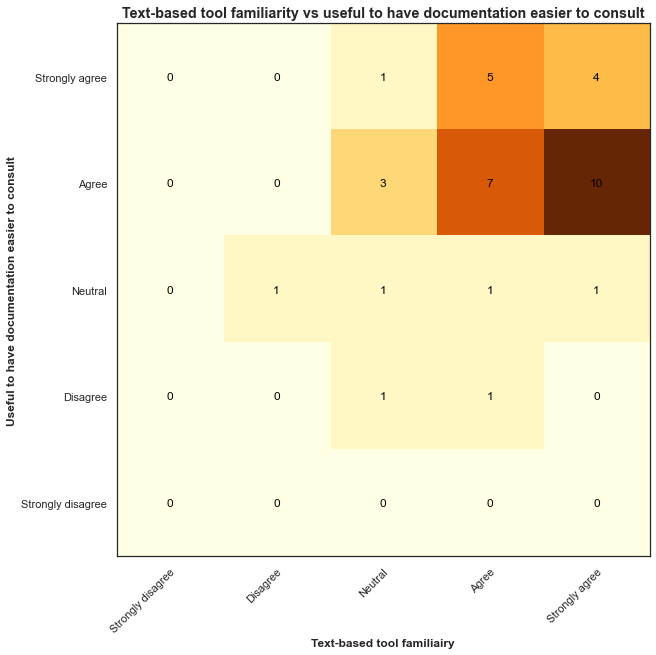

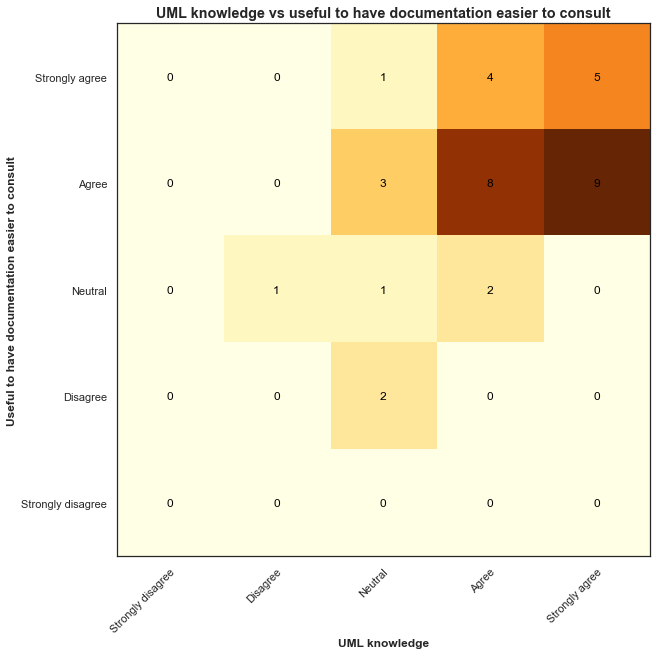

In [692]:
# plant uml familiarity vs useful to have documentation easier to consult

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[easier to consult.]')]

title = "Text-based tool familiarity vs useful to have documentation easier to consult"
xlabel = 'Text-based tool familiairy'
ylabel = 'Useful to have documentation easier to consult'

filepath = Path('../figures_usefulness/plantuml_vs_easier_consult.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to have documentation easier to consult

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful to have documentation easier to consult"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_doc_easier_consult.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

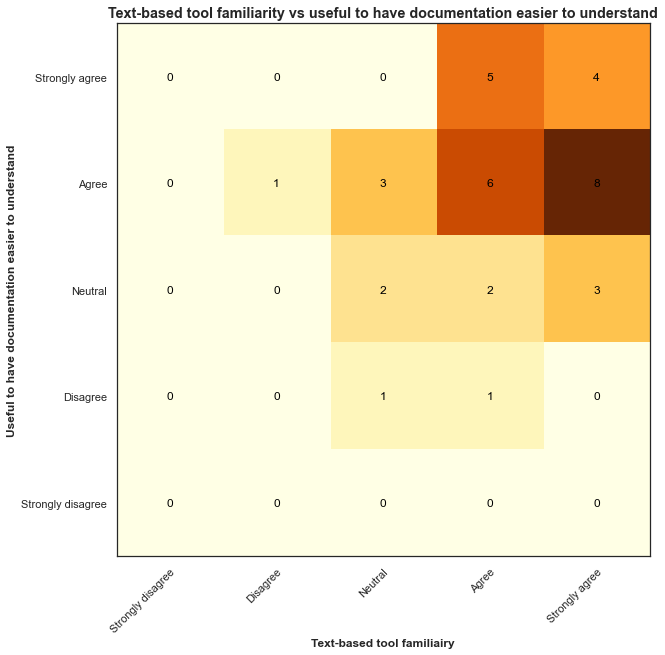

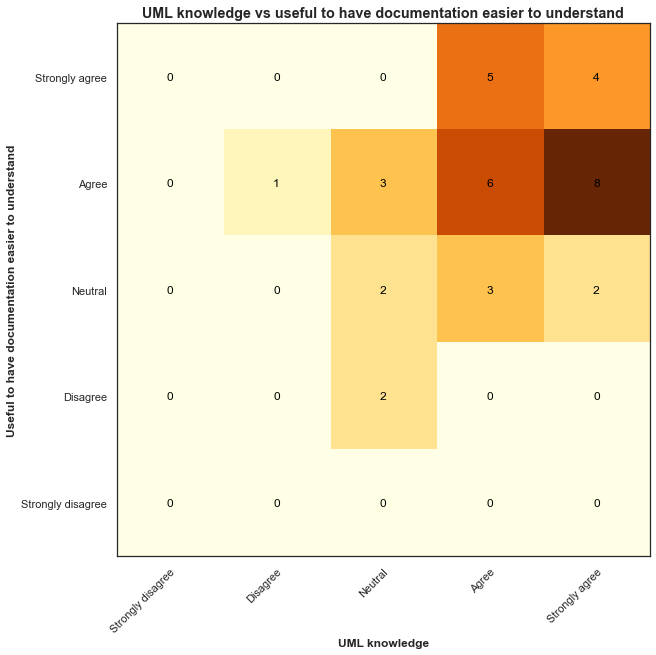

In [693]:
# plant uml familiarity vs useful to have documentation easier to understand

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[easier to understand.]')]

title = "Text-based tool familiarity vs useful to have documentation easier to understand"
xlabel = 'Text-based tool familiairy'
ylabel = 'Useful to have documentation easier to understand'

filepath = Path('../figures_usefulness/plantuml_vs_easier_understand.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to have documentation easier to understand

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful to have documentation easier to understand"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_doc_easier_understand.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

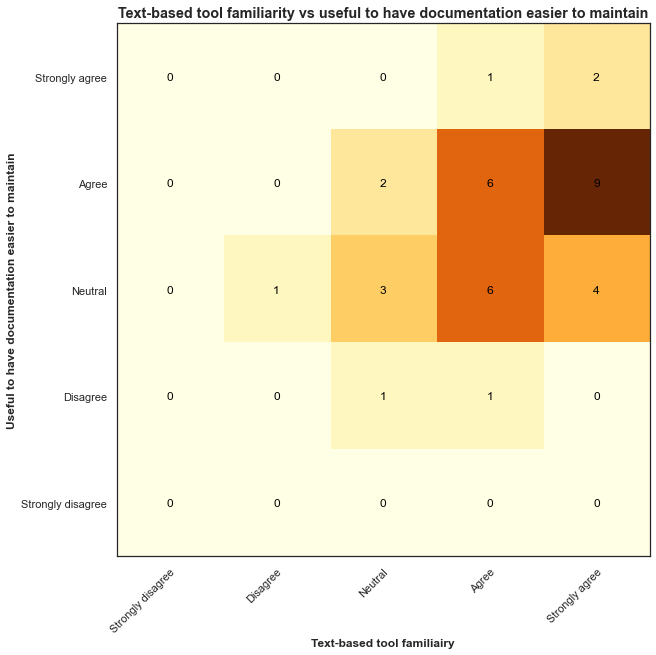

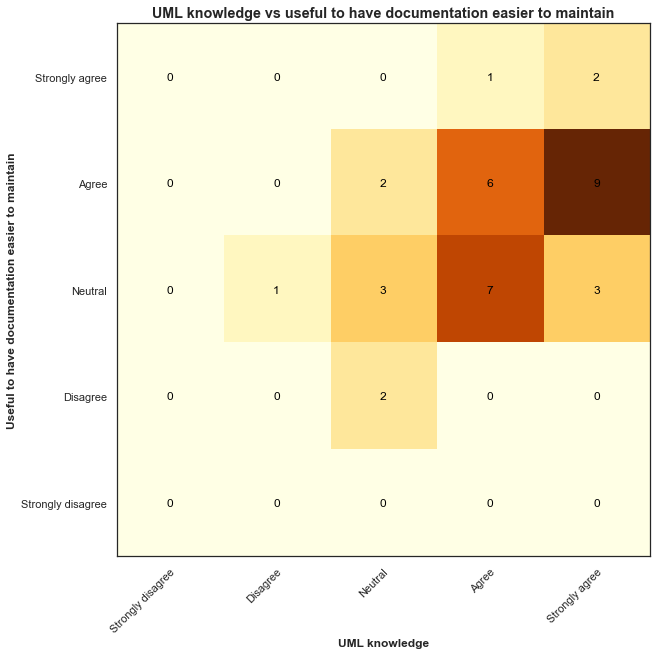

In [694]:
# plant uml familiarity vs useful to have documentation easier to maintain

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[easier to maintain.]')]

title = "Text-based tool familiarity vs useful to have documentation easier to maintain"
xlabel = 'Text-based tool familiairy'
ylabel = 'Useful to have documentation easier to maintain'

filepath = Path('../figures_usefulness/plantuml_vs_easier_maintain.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to have documentation easier to maintain

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful to have documentation easier to maintain"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_doc_easier_maintain.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

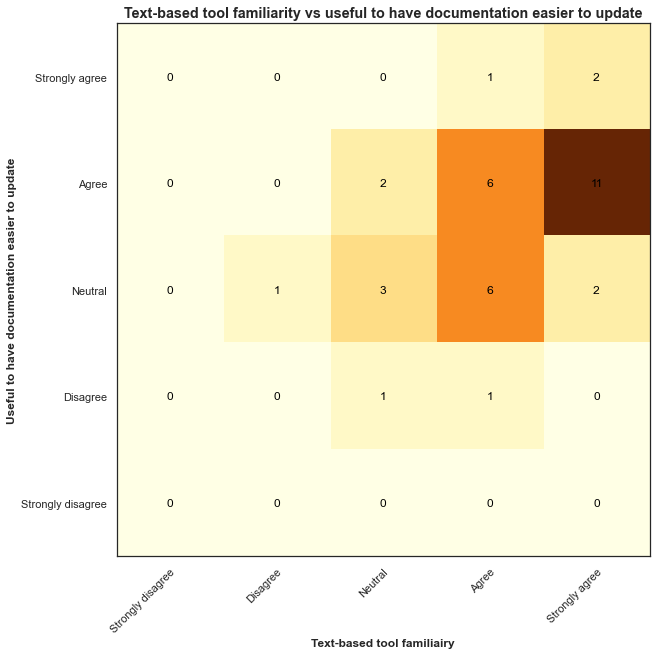

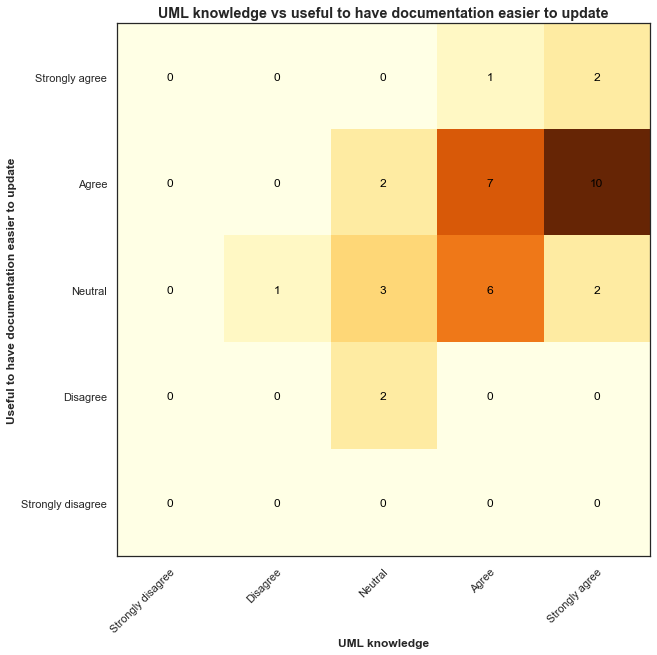

In [695]:
# plant uml familiarity vs useful to have documentation easier to update

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[easier to update.]')]

title = "Text-based tool familiarity vs useful to have documentation easier to update"
xlabel = 'Text-based tool familiairy'
ylabel = 'Useful to have documentation easier to update'

filepath = Path('../figures_usefulness/plantuml_vs_easier_update.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to have documentation easier to update

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful to have documentation easier to update"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_doc_easier_update.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

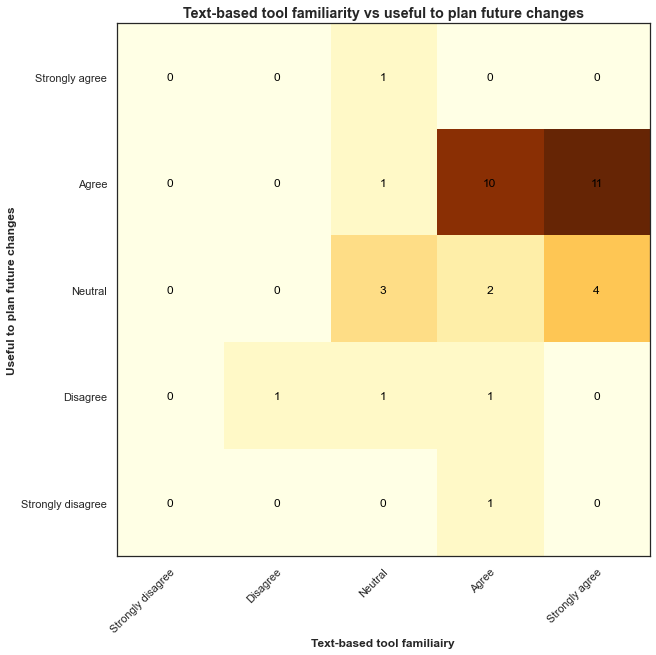

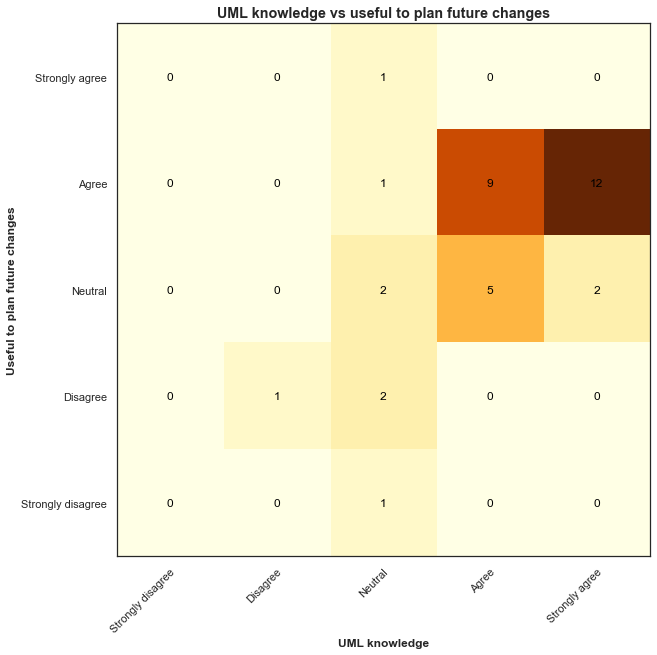

In [696]:
# plant uml familiarity vs useful to plan future changes

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[plan future changes on the architecture.]')]

title = "Text-based tool familiarity vs useful to plan future changes"
xlabel = 'Text-based tool familiairy'
ylabel = 'Useful to plan future changes'

filepath = Path('../figures_usefulness/plantuml_vs_plan_changes.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to plan future changes

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful to plan future changes"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_plan_changes.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

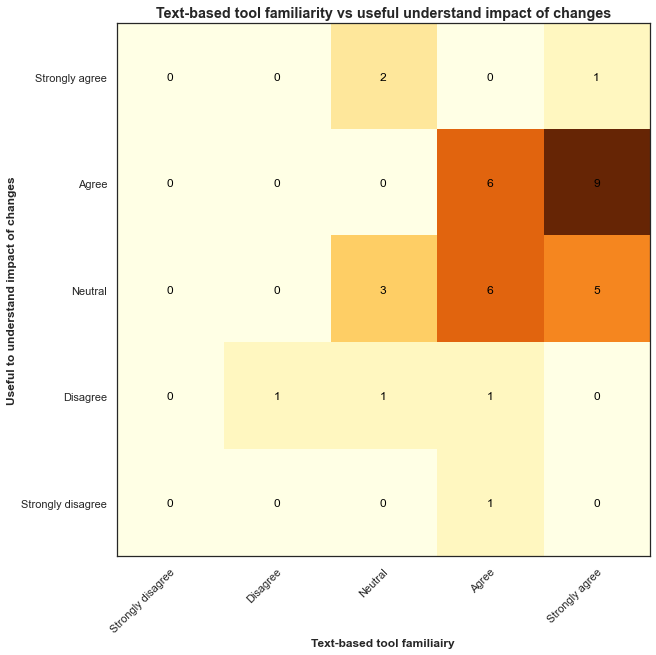

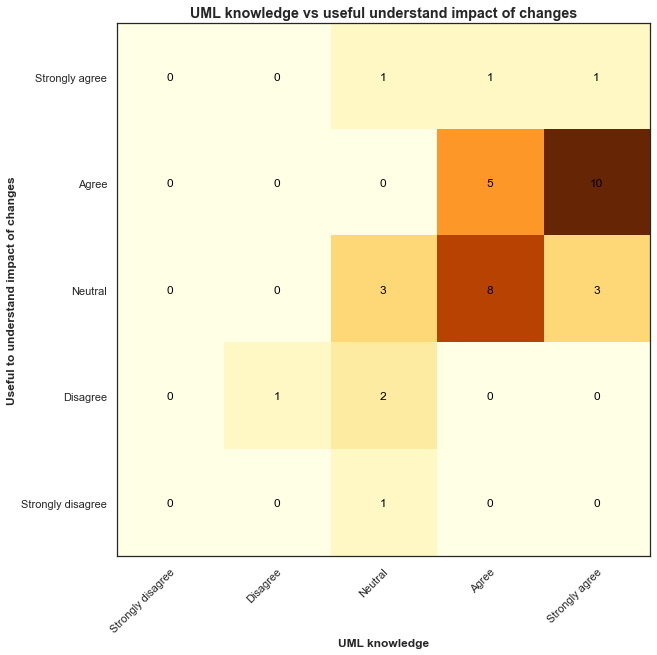

In [697]:
# plant uml familiarity vs useful to understand impact of changes

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[understand the impact of changes in the architecture.]')]

title = "Text-based tool familiarity vs useful understand impact of changes"
xlabel = 'Text-based tool familiairy'
ylabel = 'Useful to understand impact of changes'

filepath = Path('../figures_usefulness/plantuml_vs_impact_changes.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to understand impact of changes

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful understand impact of changes"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_impact_changes.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)


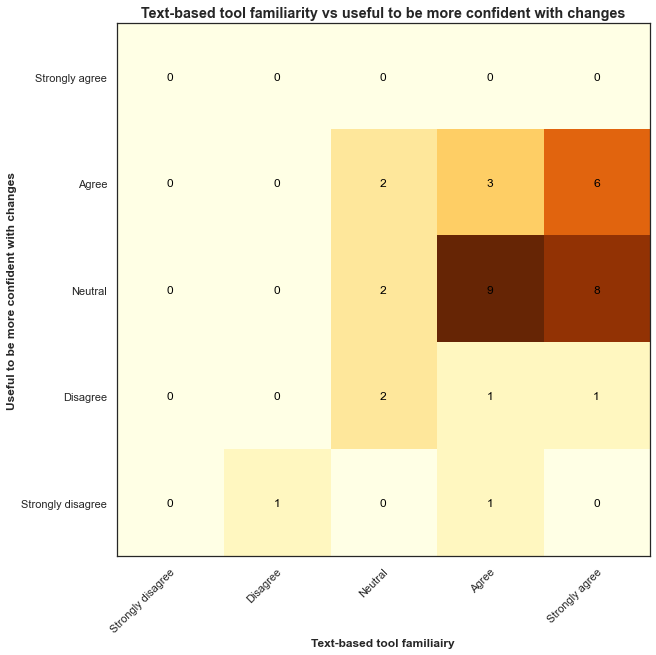

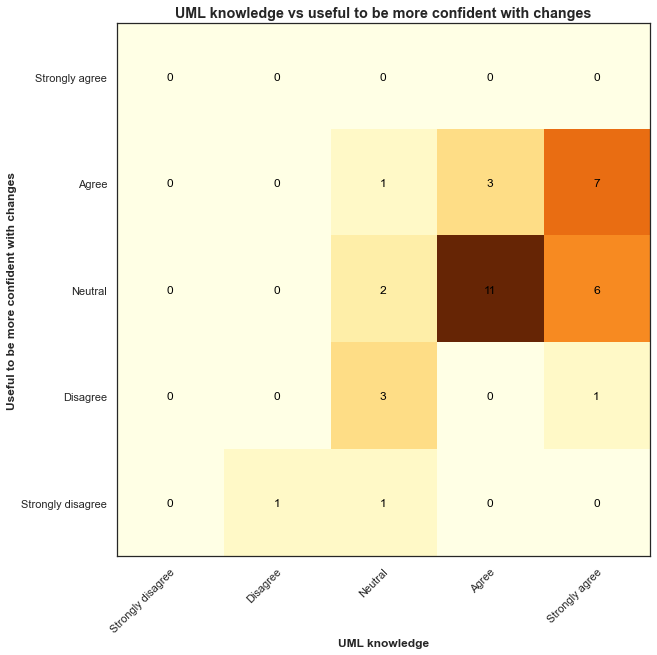

In [698]:
# plant uml familiarity vs useful to be more confident with changes

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[be more confident while introducing architectural changes.]')]

title = "Text-based tool familiarity vs useful to be more confident with changes"
xlabel = 'Text-based tool familiairy'
ylabel = 'Useful to be more confident with changes'

filepath = Path('../figures_usefulness/plantuml_vs_confident_changes.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to be more confident with changes

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful to be more confident with changes"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_confident_changes.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

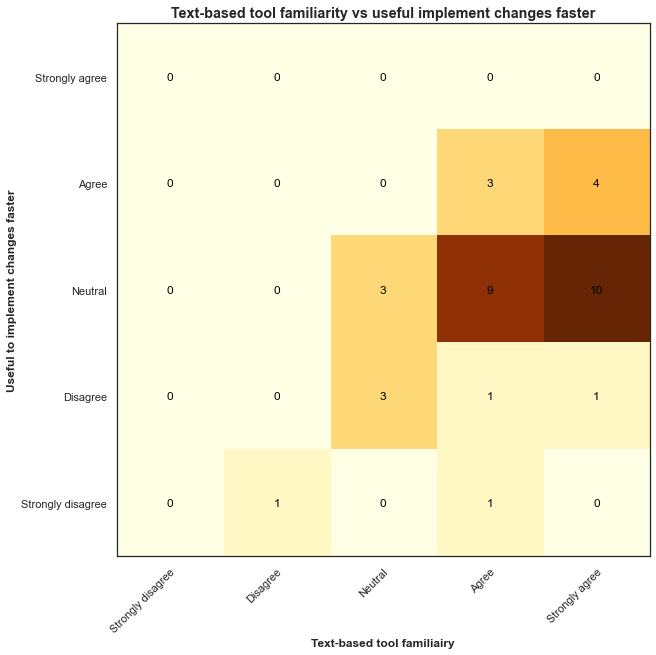

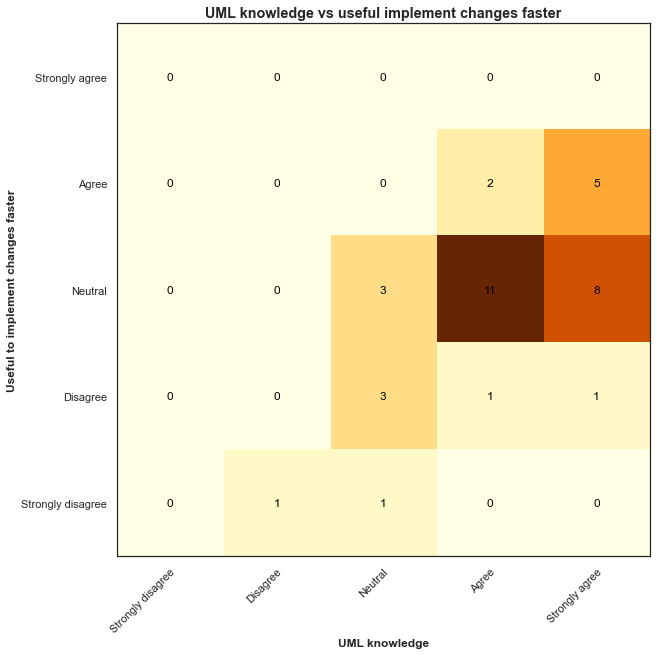

In [699]:
# plant uml familiarity vs useful to implement changes faster

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[implement architectural changes faster.]')]

title = "Text-based tool familiarity vs useful implement changes faster"
xlabel = 'Text-based tool familiairy'
ylabel = 'Useful to implement changes faster'

filepath = Path('../figures_usefulness/plantuml_vs_faster_changes.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs useful to implement changes faster

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs useful implement changes faster"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_faster_changes.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

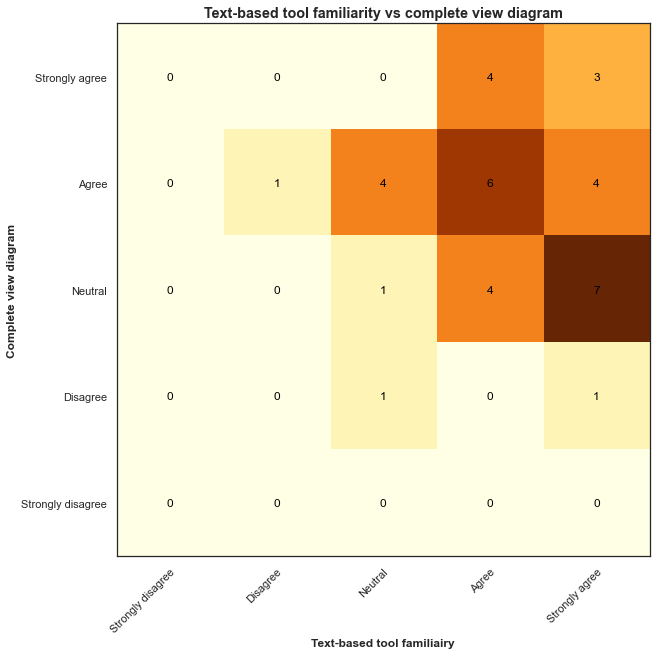

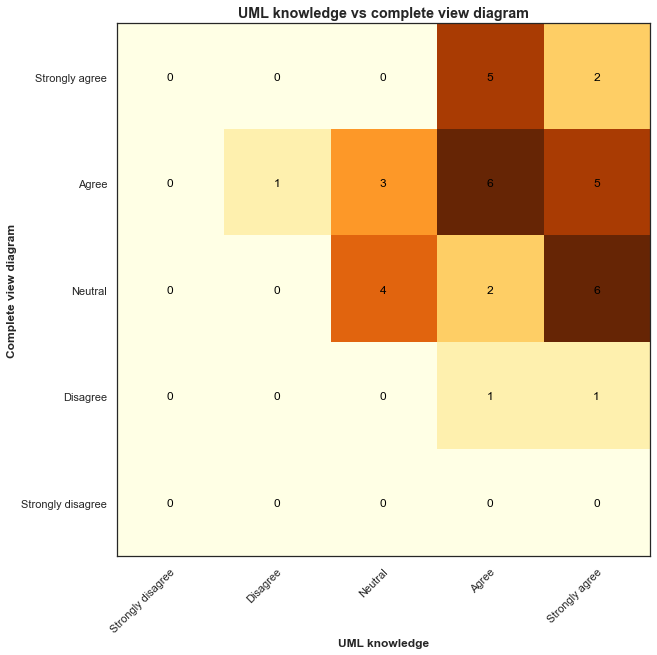

In [700]:
# plant uml familiarity vs complete view diagram

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[a complete view of the architecture.]')]

title = "Text-based tool familiarity vs complete view diagram"
xlabel = 'Text-based tool familiairy'
ylabel = 'Complete view diagram'

filepath = Path('../figures_usefulness/plantuml_vs_diagram_complete.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)


# UML knowledge vs complete view diagram

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs complete view diagram"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_diagram_complete.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

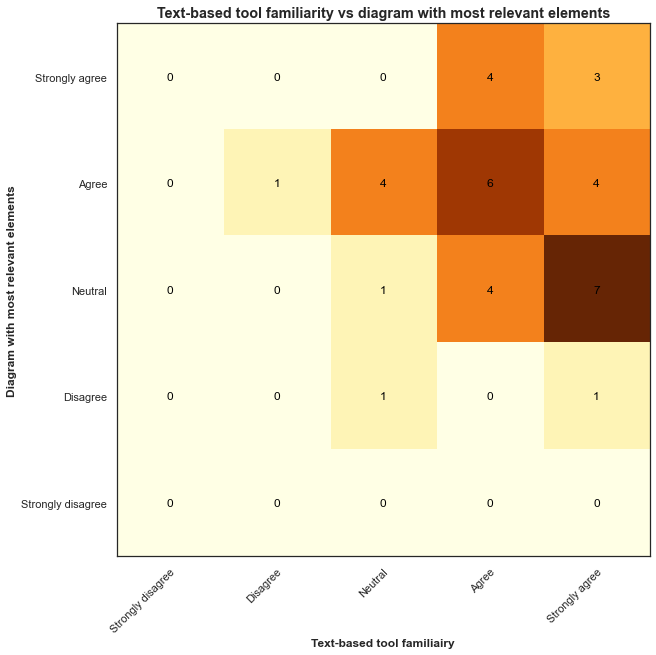

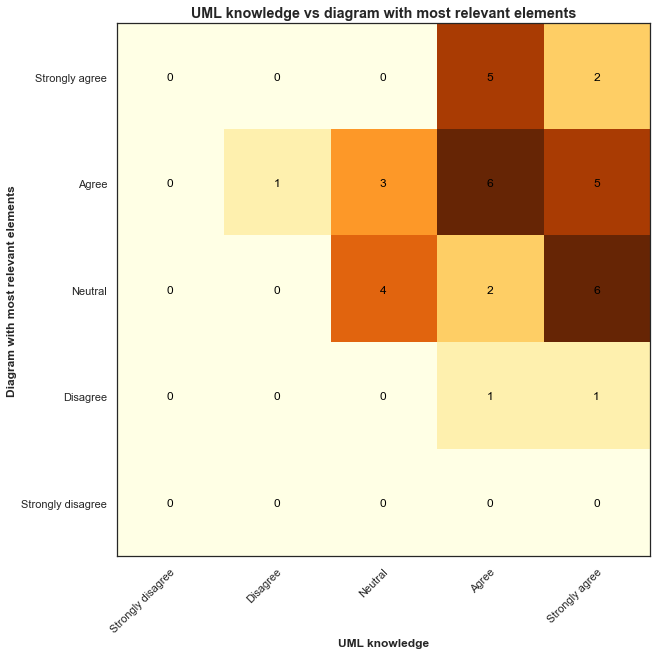

In [701]:
# plant uml familiarity vs diagram with most relevant elements

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[a complete view of the architecture.]')]

title = "Text-based tool familiarity vs diagram with most relevant elements"
xlabel = 'Text-based tool familiairy'
ylabel = 'Diagram with most relevant elements'

filepath = Path('../figures_usefulness/plantuml_vs_diagram_most_relevant.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)


# UML knowledge vs diagram with most relevant elements

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs diagram with most relevant elements"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_diagram_most_relevant.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

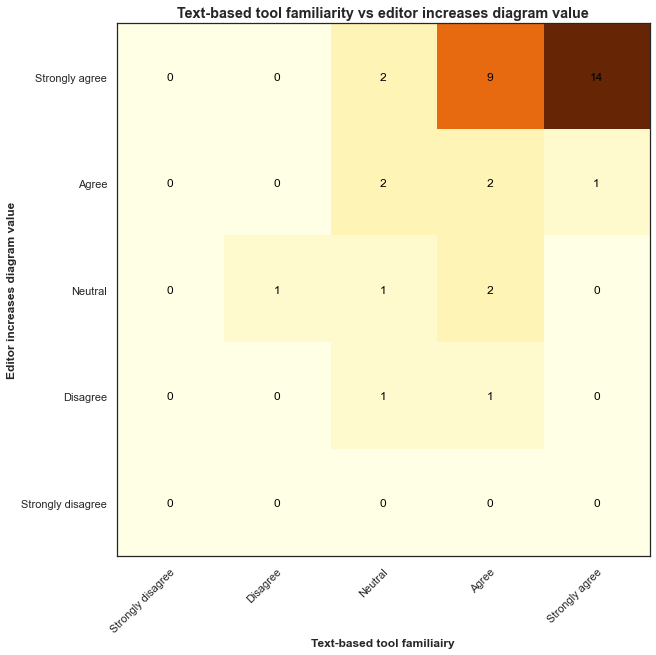

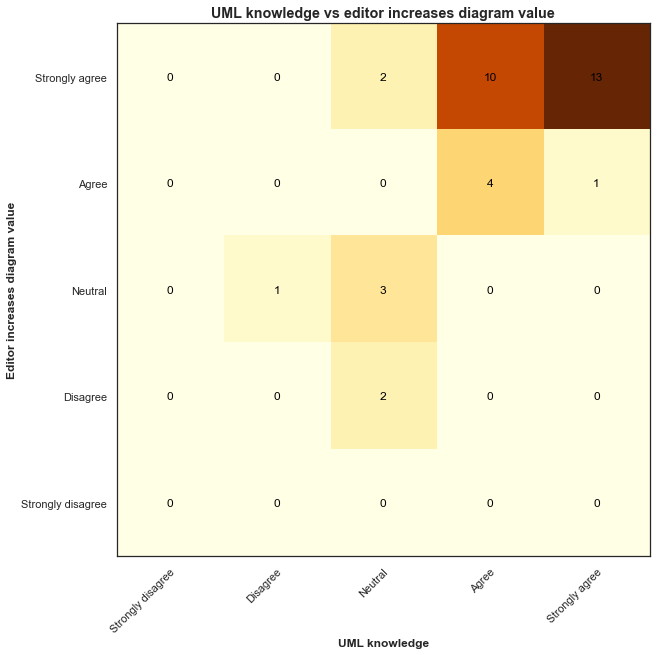

In [702]:
# plant uml familiarity vs editor increases diagram value

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[increase the diagram value.]')]

title = "Text-based tool familiarity vs editor increases diagram value"
xlabel = 'Text-based tool familiairy'
ylabel = 'Editor increases diagram value'

filepath = Path('../figures_usefulness/plantuml_vs_editor_value.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)


# UML knowledge vs editor increases diagram value

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs editor increases diagram value"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_editor_value.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

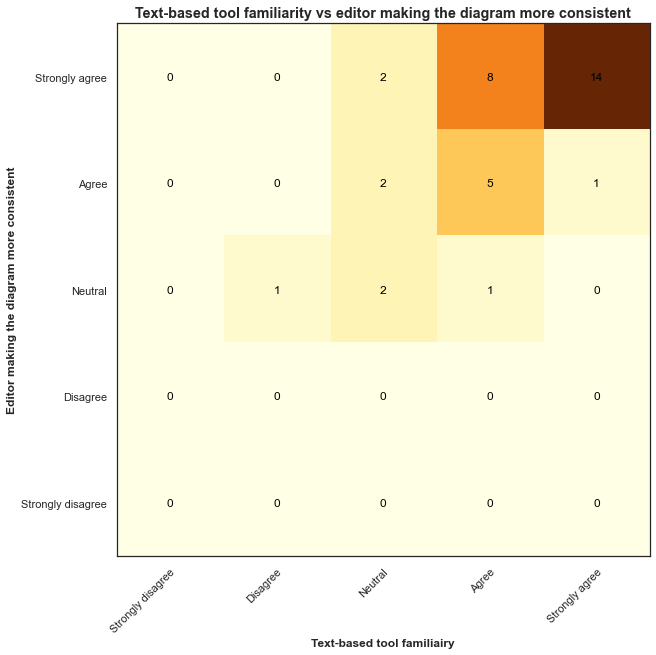

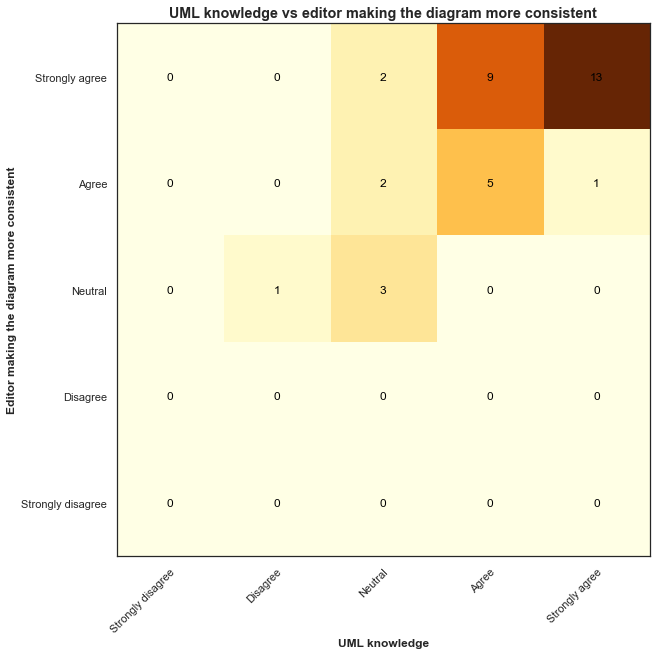

In [703]:
# plant uml familiarity vs editor making the diagram more consistent

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('[make the diagram more consistent.]')]

title = "Text-based tool familiarity vs editor making the diagram more consistent"
xlabel = 'Text-based tool familiairy'
ylabel = 'Editor making the diagram more consistent'

filepath = Path('../figures_usefulness/plantuml_vs_editor_consistent.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs editor making the diagram more consistent

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs editor making the diagram more consistent"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_editor_consistent.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

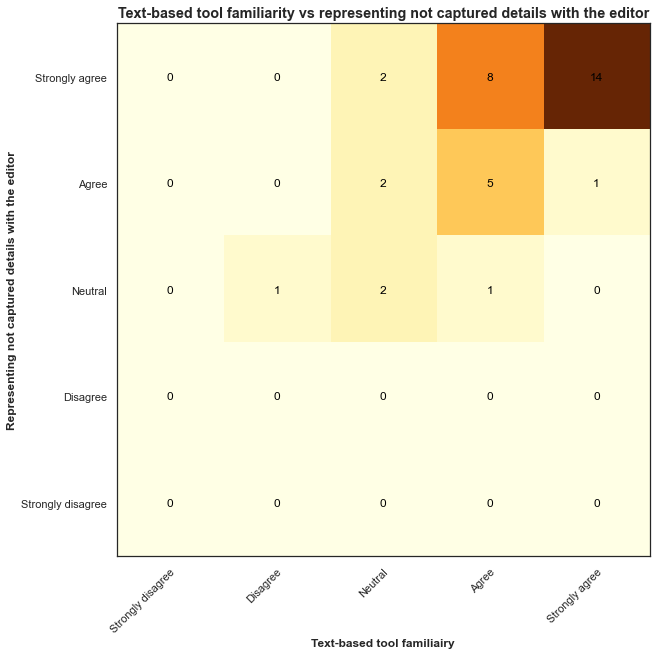

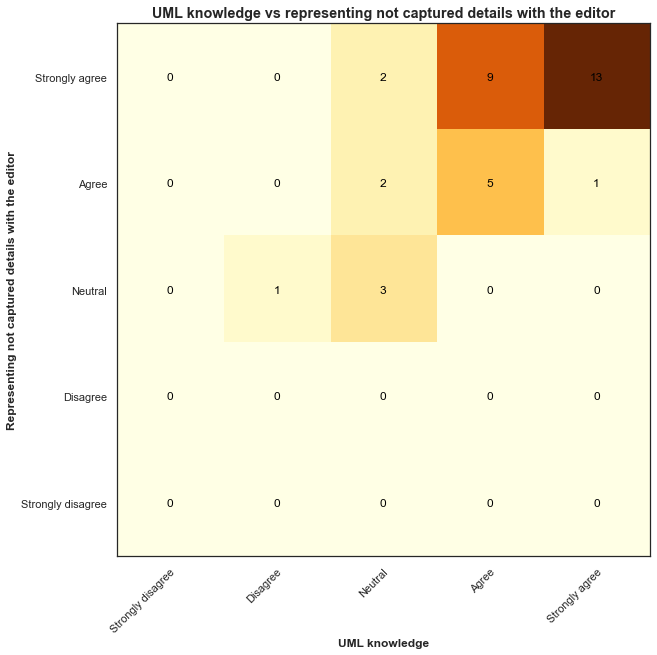

In [704]:
# plant uml familiarity vs representing not captured details with the editor

a = data[get_column_full_name('PlantUML')]
b =  data[get_column_full_name('representing details that were not automatically captured.]')]

title = "Text-based tool familiarity vs representing not captured details with the editor"
xlabel = 'Text-based tool familiairy'
ylabel = 'Representing not captured details with the editor'

filepath = Path('../figures_usefulness/plantuml_vs_editor_represent_details.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

# UML knowledge vs representing not captured details with the editor

a = data[get_column_full_name('Unified Modeling Language')]

title = "UML knowledge vs representing not captured details with the editor"
xlabel = 'UML knowledge'

filepath = Path('../figures_usefulness/uml_vs_editor_represent_details.pdf')
plot_heat_map(b, a, xlabel, ylabel, title, filepath)

In [649]:
def draw_pie_chart(labels, sizes, explode):
    size = 0.3
    dims = (11.7, 8.27)
    fig1, ax1 = plt.subplots(figsize=dims)
    cmap = plt.get_cmap("tab20c")
    colors = cmap(np.arange(3)*4)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors, textprops={'size': 'large', 'weight': 'bold'}, wedgeprops=dict(width=size, edgecolor='w'))
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

['Worst', 'Neutral', 'Better', 'Much better']


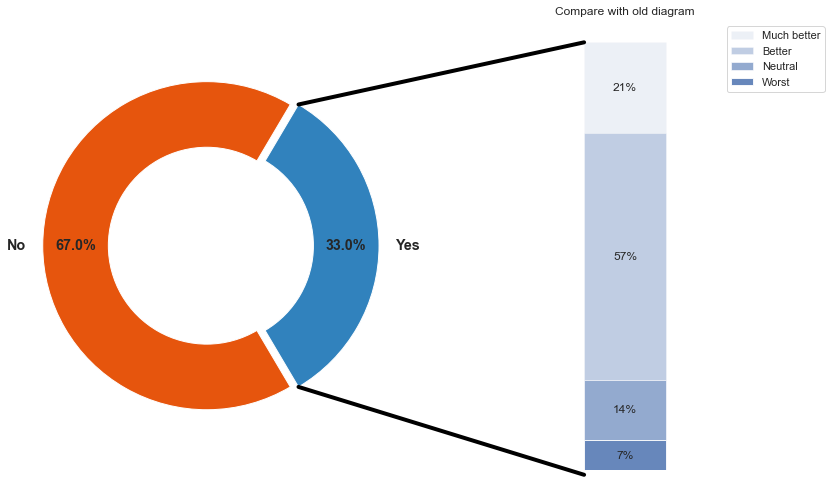

In [662]:
#### Intention to use - compare with old diagrams

# make figure and assign axis objects
dims = (14.7, 8.27)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=dims)
fig.subplots_adjust(wspace=0)

# pie chart parameters
#overall_ratios = [.27, .56, .17]
#labels = ['Approve', 'Disapprove', 'Undecided']
#explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
#angle = -180 * overall_ratios[0]
#wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
#                     labels=labels, explode=explode)


include_arch_answers = data[get_column_full_name('include an architectural diagram')]
yes_no_group = defaultdict(int)
for ans in include_arch_answers:
    if yes_no_group[ans]:
        yes_no_group[ans] = yes_no_group[ans] + 1
    else:
        yes_no_group[ans] = 1

answers_size = include_arch_answers.shape[0]
yes_no_distribution = {key: round(value / answers_size, 2) for key, value in yes_no_group.items()}

labels = list(yes_no_distribution.keys())
sizes = list(yes_no_distribution.values())
labels.reverse()
sizes.reverse()

explode = (0, 0.05) # choose which slice to explode

# rotate so that first wedge is split by the x-axis
angle = -180 * sizes[0]
cmap = plt.get_cmap("tab20c")
colors = cmap(np.arange(3)*4)
wedges, *_ = ax1.pie(sizes, autopct='%1.1f%%', startangle=angle, colors=colors,
                     labels=labels, explode=explode,  textprops={'size': 'large', 'weight': 'bold'}, wedgeprops=dict(width=0.4, edgecolor='w'), pctdistance=0.8)



age_ratios = [0.33, 0.54, 0.07, 0.06]
age_labels = ['Under 35', '35-49', '50-65', 'Over 65']
bottom = 1
width = .2

# Intention to use - compare with old diagrams
# bar chart parameters


include_arch_answers = data[get_column_full_name('how do you compare it with the one generated by Infragenie')]
valid_choices = ['Much worst', 'Worst', 'Neutral', 'Better', 'Much better']

yes_no_group = defaultdict(int)
invalid_answers = 0
for ans in include_arch_answers:
    if ans not in valid_choices:
        invalid_answers = invalid_answers + 1
        continue
    if yes_no_group[ans]:
        yes_no_group[ans] = yes_no_group[ans] + 1
    else:
        yes_no_group[ans] = 1

answers_size = include_arch_answers.shape[0]
yes_no_distribution = {key: round(value / (answers_size - invalid_answers), 2) for key, value in yes_no_group.items()}


yes_no_distribution_correct_order = {
    'Worst': yes_no_distribution['Worst'],
    'Neutral': yes_no_distribution['Neutral'],
    'Better': yes_no_distribution['Better'],
    'Much better': yes_no_distribution['Much better'],
}


compare_labels = list(yes_no_distribution_correct_order.keys())
compare_ratios = list(yes_no_distribution_correct_order.values())

print(compare_labels)

#explode = (0, 0, 0.1, 0) # choose which slice to explode
#draw_pie_chart(labels, sizes, explode)

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(compare_ratios, compare_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Compare with old diagram')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r

bar_height = 1
#bar_height = sum(compare_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

filepath = Path('../figures/compare_with_old_diagram.pdf')
plt.savefig(filepath, format='pdf', bbox_inches='tight')
plt.show()

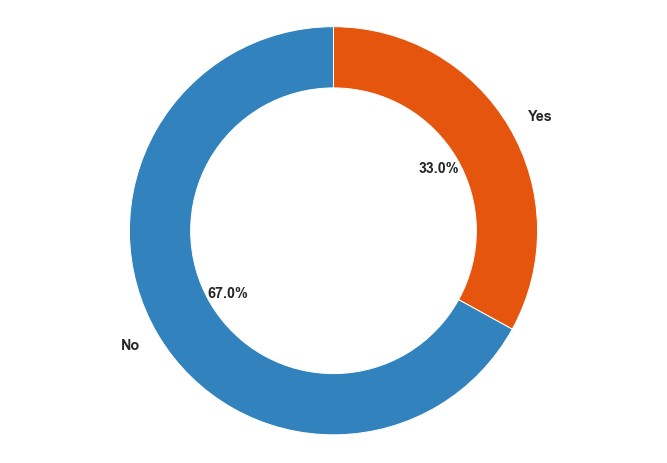

In [408]:
# Intention to use - compare with old diagrams

include_arch_answers = data[get_column_full_name('include an architectural diagram')]

yes_no_group = defaultdict(int)
for ans in include_arch_answers:
    if yes_no_group[ans]:
        yes_no_group[ans] = yes_no_group[ans] + 1
    else:
        yes_no_group[ans] = 1

answers_size = include_arch_answers.shape[0]
yes_no_distribution = {key: round(value / answers_size, 2) for key, value in yes_no_group.items()}

labels = list(yes_no_distribution.keys())
sizes = list(yes_no_distribution.values())

explode = (0, 0) # choose which slice to explode

draw_pie_chart(labels, sizes, explode)

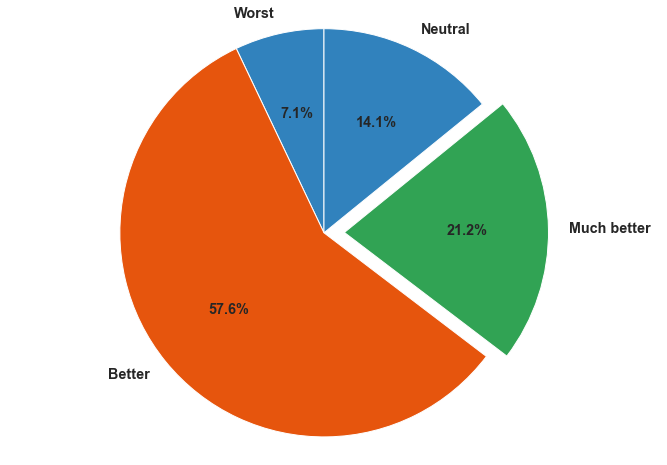

In [159]:
# Intention to use - compare with old diagrams

include_arch_answers = data[get_column_full_name('how do you compare it with the one generated by Infragenie')]
valid_choices = ['Much worst', 'Worst', 'Neutral', 'Better', 'Much better']

yes_no_group = defaultdict(int)
invalid_answers = 0
for ans in include_arch_answers:
    if ans not in valid_choices:
        invalid_answers = invalid_answers + 1
        continue
    if yes_no_group[ans]:
        yes_no_group[ans] = yes_no_group[ans] + 1
    else:
        yes_no_group[ans] = 1

answers_size = include_arch_answers.shape[0]
yes_no_distribution = {key: round(value / (answers_size - invalid_answers), 2) for key, value in yes_no_group.items()}

labels = list(yes_no_distribution.keys())
sizes = list(yes_no_distribution.values())

explode = (0, 0, 0.1, 0) # choose which slice to explode

draw_pie_chart(labels, sizes, explode)

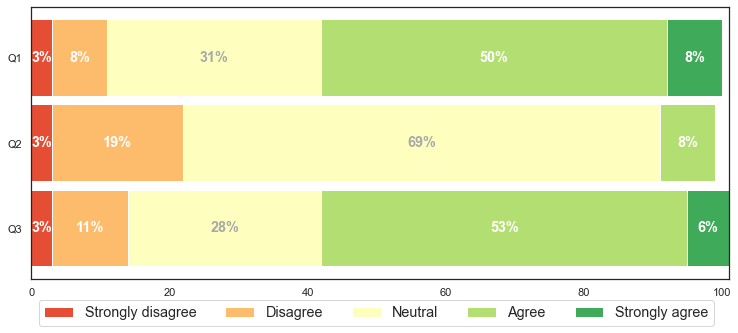

(<Figure size 900x360 with 1 Axes>, <AxesSubplot:>)

In [666]:
# Intention to use - question

q1_answers = data[get_column_full_name('[add diagrams generated by Infragenie to my projects.]')]
q2_answers = data[get_column_full_name('[use infragenie to visualize and plan changes in the architecture.]')]
q3_answers = data[get_column_full_name('[use infragenie in new projects.]')]

results = {
    'Q1': get_likert_data_sorted(q1_answers),
    'Q2': get_likert_data_sorted(q2_answers),
    'Q3': get_likert_data_sorted(q3_answers),
}

filepath = Path('../figures/intention-to-use.pdf')
generate_likert_graph(results, filepath)

/var/folders/03/hllvd2q10f58y1x9ys6xdqwc0000gq/T/ipykernel_6706/3281927539.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answers_by_experience[row['ExpValue']] = answers_by_experience[row['ExpValue']].append(row.iloc[1:].transform(lambda item: likert_scale_order(item)))
/var/folders/03/hllvd2q10f58y1x9ys6xdqwc0000gq/T/ipykernel_6706/3281927539.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answers_by_experience[row['ExpValue']] = answers_by_experience[row['ExpValue']].append(row.iloc[1:].transform(lambda item: likert_scale_order(item)))
/var/folders/03/hllvd2q10f58y1x9ys6xdqwc0000gq/T/ipykernel_6706/3281927539.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answers_by_experience[row['ExpValue']] = answe

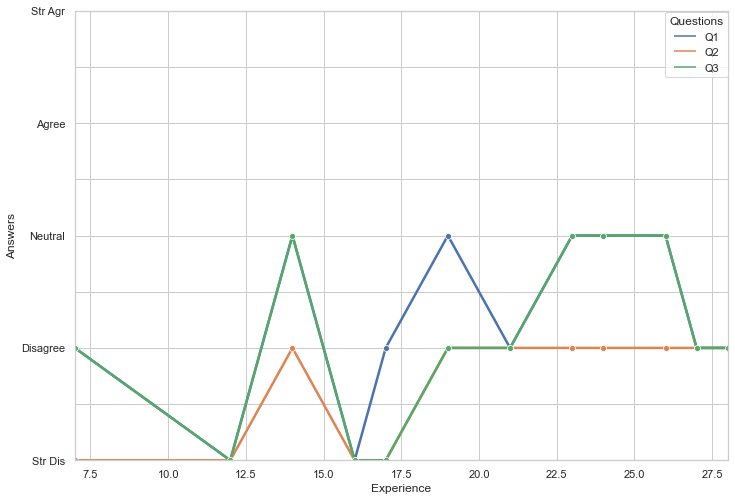

In [191]:
sns.set_theme(style="whitegrid")

answers_keywords = ['[add diagrams generated by Infragenie to my projects.]',
                   '[use infragenie to visualize and plan changes in the architecture.]',
                    '[use infragenie in new projects.]',
                   ]
columns=['Q1', 'Q2', 'Q3']



ease_of_use_raw_data = data.iloc[:, 36:40]

exp, average_responses = get_average_responses_by_experience(ease_of_use_raw_data, answers_keywords)
plot_response_by_experience_relation(columns)

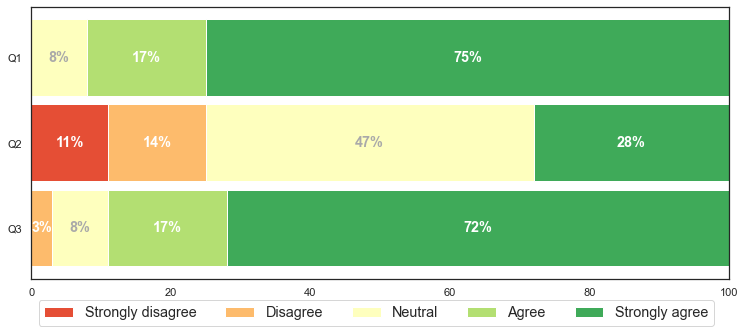

(<Figure size 900x360 with 1 Axes>, <AxesSubplot:>)

In [667]:
# Improvements

q1_answers = data[get_column_full_name('[more UML elements were available to use.]')]
q2_answers = data[get_column_full_name("[it wasn't restricted to UML elements.]")]
q3_answers = data[get_column_full_name('[it automatically detected architectural changes')]

results = {
    'Q1': get_likert_data_sorted(q1_answers),
    'Q2': get_likert_data_sorted(q2_answers),
    'Q3': get_likert_data_sorted(q3_answers),
}

filepath = Path('../figures/improvements.pdf')
generate_likert_graph(results, filepath)

/var/folders/03/hllvd2q10f58y1x9ys6xdqwc0000gq/T/ipykernel_6706/3281927539.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answers_by_experience[row['ExpValue']] = answers_by_experience[row['ExpValue']].append(row.iloc[1:].transform(lambda item: likert_scale_order(item)))
/var/folders/03/hllvd2q10f58y1x9ys6xdqwc0000gq/T/ipykernel_6706/3281927539.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answers_by_experience[row['ExpValue']] = answers_by_experience[row['ExpValue']].append(row.iloc[1:].transform(lambda item: likert_scale_order(item)))
/var/folders/03/hllvd2q10f58y1x9ys6xdqwc0000gq/T/ipykernel_6706/3281927539.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answers_by_experience[row['ExpValue']] = answe

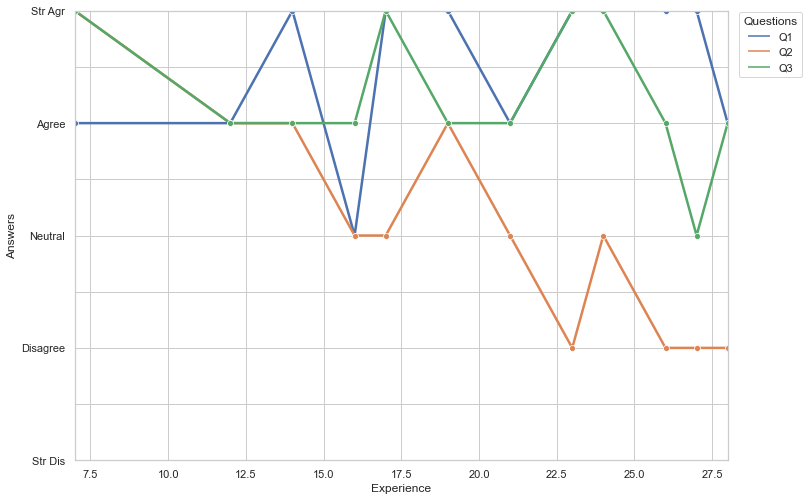

In [196]:
sns.set_theme(style="whitegrid")

answers_keywords = ['[more UML elements were available to use.]',
                   '[it wasn\'t restricted to UML elements.]',
                    '[it automatically detected architectural changes',
                   ]
columns=['Q1', 'Q2', 'Q3']



ease_of_use_raw_data = data.iloc[:, 39:42]

exp, average_responses = get_average_responses_by_experience(ease_of_use_raw_data, answers_keywords)
plot_response_by_experience_relation(columns)